In [145]:
import pandas as pd
import numpy as np
import os

# Check current working directory (optional)
print("Current working directory:", os.getcwd())

# Read the CSV file
df = pd.read_csv(r'/root/clean AAC concrete dataset large ratio.csv')

# Remove the row where the "Ref." column equals "[107]"
df = df[df["Ref."] != "[107]"]

# Define original feature columns and target columns
original_feature_cols = [
    "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "SO3",
    "TiO2", "P2O5", "SrO", "Mn2O3", "MnO", "LOI", 
    "AL/B", "SH/SS", "Ms", "Ag/B", "W/B", "Sp/B",
    "Initial curing time (day)", "Initial curing temp (C)", 
    "Initial curing rest time (day)", "Final curing temp (C)", 
    "Concentration (M) NaOH"
]

target_cols = ["7d CS", "28d CS"]

# Drop unwanted columns: "MnO", "Initial curing time (day)", "Initial curing rest time (day)"
cols_to_drop = ["MnO", "Initial curing time (day)", "Initial curing rest time (day)"]
df = df.drop(columns=cols_to_drop)

# Update the feature columns list accordingly (remove dropped columns)
feature_cols = [
    "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "SO3",
    "TiO2", "P2O5", "SrO", "Mn2O3", "LOI", 
    "AL/B", "SH/SS", "Ms", "Ag/B", "W/B", "Sp/B",
    "Initial curing temp (C)", "Final curing temp (C)", 
    "Concentration (M) NaOH"
]

# Convert target columns to numeric (replacing empty strings with NaN)
for col in target_cols:
    df[col] = pd.to_numeric(df[col].replace(' ', np.nan), errors='coerce')

# Print missing values in target columns
print("Missing values in target columns:")
print(df[target_cols].isnull().sum())

# Drop rows with missing target values
df_clean = df.dropna(subset=target_cols)
print(f"Dataset shape after dropping rows with missing targets: {df_clean.shape}")

# Fill missing values in specific feature columns using the median
df_clean["Na2O"] = df_clean["Na2O"].fillna(df_clean["Na2O"].median())
df_clean["Concentration (M) NaOH"] = df_clean["Concentration (M) NaOH"].fillna(df_clean["Concentration (M) NaOH"].median())

# Extract feature and target arrays
X = df_clean[feature_cols].values
y_7 = df_clean["7d CS"].values
y_28 = df_clean["28d CS"].values

print("X shape:", X.shape)
print("y_7 shape:", y_7.shape)
print("y_28 shape:", y_28.shape)


Current working directory: /root
Missing values in target columns:
7d CS     621
28d CS    667
dtype: int64
Dataset shape after dropping rows with missing targets: (603, 73)
X shape: (603, 22)
y_7 shape: (603,)
y_28 shape: (603,)


/tmp/ipykernel_1179/1748827572.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Na2O"] = df_clean["Na2O"].fillna(df_clean["Na2O"].median())
/tmp/ipykernel_1179/1748827572.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Concentration (M) NaOH"] = df_clean["Concentration (M) NaOH"].fillna(df_clean["Concentration (M) NaOH"].median())


In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy

# =============================================================================
# STEP 1: PROPER TRAIN-TEST SPLIT (DO THIS FIRST - NO PREPROCESSING YET)
# =============================================================================
print("=== STEP 1: Initial Data Split ===")
print(f"Original dataset shape: X{X.shape}, y_7{y_7.shape}, y_28{y_28.shape}")

# Split indices first - this is the ONLY thing we do before any preprocessing
train_indices, test_indices = train_test_split(
    np.arange(len(X)), test_size=0.2, random_state=42, stratify=None
)

print(f"Training samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Split the raw data using indices
X_train_raw = X[train_indices]
X_test_raw = X[test_indices]
y_7_train_raw = y_7[train_indices]
y_7_test_raw = y_7[test_indices]
y_28_train_raw = y_28[train_indices]
y_28_test_raw = y_28[test_indices]

# =============================================================================
# STEP 2: FEATURE SCALING (FIT ON TRAINING ONLY)
# =============================================================================
print("\n=== STEP 2: Feature Scaling ===")

# Fit scaler on training data ONLY
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
X_test_scaled = feature_scaler.transform(X_test_raw)  # Only transform, never fit on test

print(f"Training features scaled shape: {X_train_scaled.shape}")
print(f"Test features scaled shape: {X_test_scaled.shape}")

# Verify scaling worked correctly
print(f"Training features mean: {X_train_scaled.mean(axis=0)[:3]}... (should be ~0)")
print(f"Training features std: {X_train_scaled.std(axis=0)[:3]}... (should be ~1)")

# =============================================================================
# STEP 3: TARGET SCALING - GLOBAL SCALER (FIT ON TRAINING ONLY)
# =============================================================================
print("\n=== STEP 3: Target Scaling - Global Scaler ===")

# Combine ONLY training targets to fit the global scaler
all_train_targets = np.concatenate([y_7_train_raw, y_28_train_raw])
print(f"Combined training targets shape: {all_train_targets.shape}")
print(f"Training targets range: [{all_train_targets.min():.2f}, {all_train_targets.max():.2f}]")

# Fit global scaler on training data ONLY
global_target_scaler = StandardScaler()
global_target_scaler.fit(all_train_targets.reshape(-1, 1))

# Transform both training and test targets using the same fitted scaler
y_7_train_scaled = global_target_scaler.transform(y_7_train_raw.reshape(-1, 1)).flatten()
y_28_train_scaled = global_target_scaler.transform(y_28_train_raw.reshape(-1, 1)).flatten()
y_7_test_scaled = global_target_scaler.transform(y_7_test_raw.reshape(-1, 1)).flatten()
y_28_test_scaled = global_target_scaler.transform(y_28_test_raw.reshape(-1, 1)).flatten()

print(f"Scaled training targets - 7d: mean={y_7_train_scaled.mean():.3f}, std={y_7_train_scaled.std():.3f}")
print(f"Scaled training targets - 28d: mean={y_28_train_scaled.mean():.3f}, std={y_28_train_scaled.std():.3f}")

# =============================================================================
# STEP 4: DATASET AND MODEL DEFINITIONS
# =============================================================================
print("\n=== STEP 4: Dataset and Model Setup ===")

class ConcreteDatasetScaled(Dataset):
    def __init__(self, features, y_7_scaled, y_28_scaled):
        self.z = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(np.vstack((y_7_scaled, y_28_scaled)).T, dtype=torch.float32)
        self.t = torch.tensor([7.0, 28.0], dtype=torch.float32)
    
    def __len__(self):
        return self.z.shape[0]
    
    def __getitem__(self, idx):
        return self.z[idx], self.t, self.y[idx]

class AGPModelGP_v2(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128, 64], dropout_rate=0.05):
        super(AGPModelGP_v2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(hidden_dims[2], 5)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        out = self.fc4(x)
        
        theta1 = self.softplus(out[:, 0])
        theta2 = out[:, 1]
        l = torch.exp(out[:, 2])
        sigma_f = torch.exp(out[:, 3])
        sigma_n = torch.exp(out[:, 4])
        
        return theta1, theta2, l, sigma_f, sigma_n

def gp_neg_log_likelihood(theta1, theta2, l, sigma_f, sigma_n, t, y, epsilon=1e-6):
    batch_size = y.shape[0]
    n_t = t.shape[0]
    total_nll = 0.0
    log_t = torch.log(t + epsilon)
    
    for i in range(batch_size):
        m = theta1[i] * log_t + theta2[i]
        diff = t.unsqueeze(0) - t.unsqueeze(1)
        K = sigma_f[i]**2 * torch.exp(-0.5 * (diff**2) / (l[i]**2))
        K = K + sigma_n[i]**2 * torch.eye(n_t, device=K.device)
        K = K + epsilon * torch.eye(n_t, device=K.device)
        
        L_mat = torch.linalg.cholesky(K)
        diff_y = (y[i] - m).unsqueeze(1)
        alpha = torch.cholesky_solve(diff_y, L_mat)
        log_det_K = 2.0 * torch.sum(torch.log(torch.diag(L_mat)))
        nll = 0.5 * diff_y.t() @ alpha + 0.5 * log_det_K + 0.5 * n_t * np.log(2 * np.pi)
        total_nll += nll.squeeze()
    
    return total_nll / batch_size

# =============================================================================
# STEP 5: CREATE DATASETS AND DATALOADERS
# =============================================================================
print("\n=== STEP 5: Creating Datasets ===")

# Create datasets
train_dataset = ConcreteDatasetScaled(X_train_scaled, y_7_train_scaled, y_28_train_scaled)
test_dataset = ConcreteDatasetScaled(X_test_scaled, y_7_test_scaled, y_28_test_scaled)

# Create dataloaders
batch_size = 32  # You can adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))  # Full batch for test

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Training batches: {len(train_loader)}")

# =============================================================================
# STEP 6: MODEL TRAINING
# =============================================================================
print("\n=== STEP 6: Model Training ===")

# Set hyperparameters
best_dropout = 0.1
best_lr = 0.002
best_hidden_dims = [128, 128, 64]
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print(f"Hyperparameters: dropout={best_dropout}, lr={best_lr}, hidden_dims={best_hidden_dims}")

# Initialize model
input_dim = X_train_scaled.shape[1]
model = AGPModelGP_v2(input_dim, hidden_dims=best_hidden_dims, dropout_rate=best_dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Training loop
model.train()
train_losses = []
times = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

print("Starting training...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for z_batch, _, y_batch in train_loader:
        z_batch = z_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        theta1, theta2, l, sigma_f, sigma_n = model(z_batch)
        loss = gp_neg_log_likelihood(theta1, theta2, l, sigma_f, sigma_n, times, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("Training completed!")


=== STEP 1: Initial Data Split ===
Original dataset shape: X(603, 22), y_7(603,), y_28(603,)
Training samples: 482
Test samples: 121

=== STEP 2: Feature Scaling ===
Training features scaled shape: (482, 22)
Test features scaled shape: (121, 22)
Training features mean: [ 5.55272748e-15 -1.76069394e-15 -3.03123133e-16]... (should be ~0)
Training features std: [1. 1. 1.]... (should be ~1)

=== STEP 3: Target Scaling - Global Scaler ===
Combined training targets shape: (964,)
Training targets range: [2.90, 77.36]
Scaled training targets - 7d: mean=-0.225, std=0.945
Scaled training targets - 28d: mean=0.225, std=1.002

=== STEP 4: Dataset and Model Setup ===

=== STEP 5: Creating Datasets ===
Training dataset size: 482
Test dataset size: 121
Training batches: 16

=== STEP 6: Model Training ===
Using device: cuda
Hyperparameters: dropout=0.1, lr=0.002, hidden_dims=[128, 128, 64]
Model initialized with 28677 parameters
Starting training...
Epoch [50/200], Average Loss: 0.4971
Epoch [100/200]


=== STEP 7: Inference with Uncertainty Quantification ===
Performing 100 MC forward passes for uncertainty estimation...
MC samples shape: (121, 100, 2)
Total uncertainty shape: (121, 2)

=== STEP 8: Inverse Scaling and Metrics ===

TEST SET RESULTS WITH UNCERTAINTY QUANTIFICATION

7-DAY CONCRETE STRENGTH:
  R² Score: 0.7811
  MAE: 4.7542 MPa
  RMSE: 6.1757 MPa
  PICP (95% Coverage): 0.7851
  MPIW (Mean PI Width): 14.6814 MPa
  Mean Noise σ_n: 2.3738 MPa
  Mean Aleatoric σ_ale: 2.4540 MPa
  Mean Epistemic σ_epi: 2.7035 MPa

28-DAY CONCRETE STRENGTH:
  R² Score: 0.7514
  MAE: 5.1755 MPa
  RMSE: 6.6524 MPa
  PICP (95% Coverage): 0.7851
  MPIW (Mean PI Width): 15.3055 MPa
  Mean Noise σ_n: 2.3738 MPa
  Mean Aleatoric σ_ale: 2.4540 MPa
  Mean Epistemic σ_epi: 2.9175 MPa


Visualizing first 10 test samples...


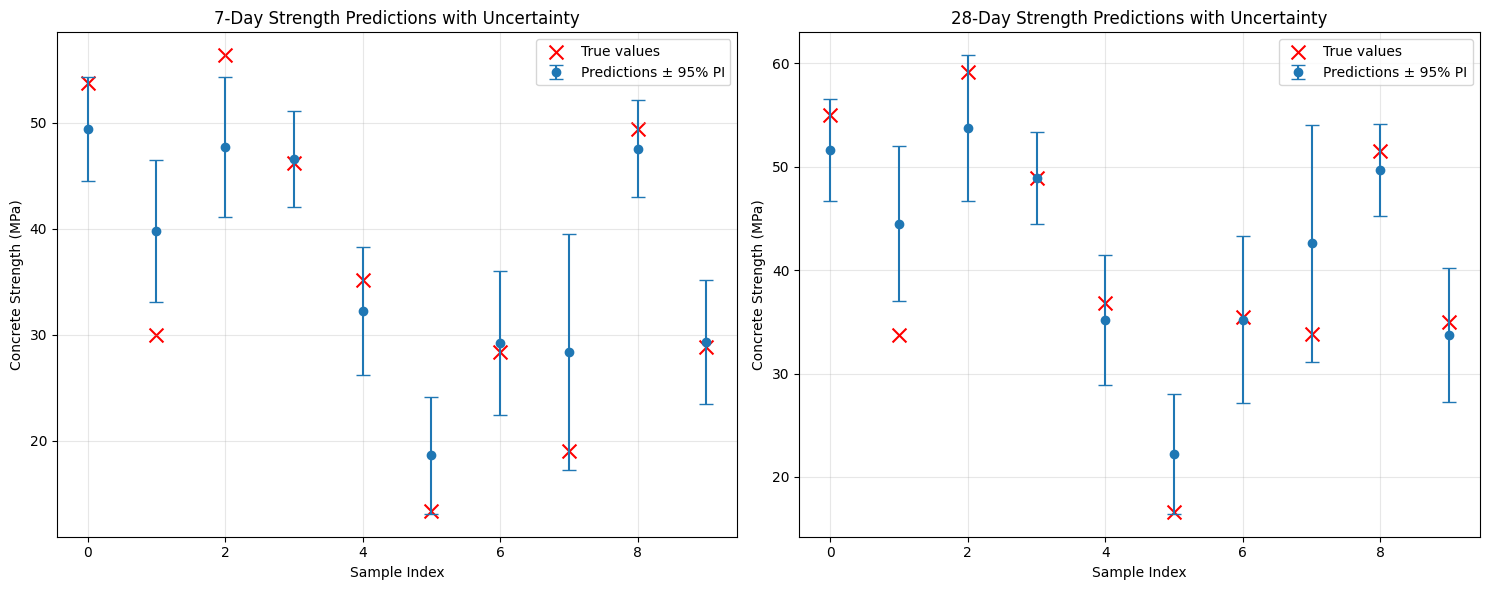

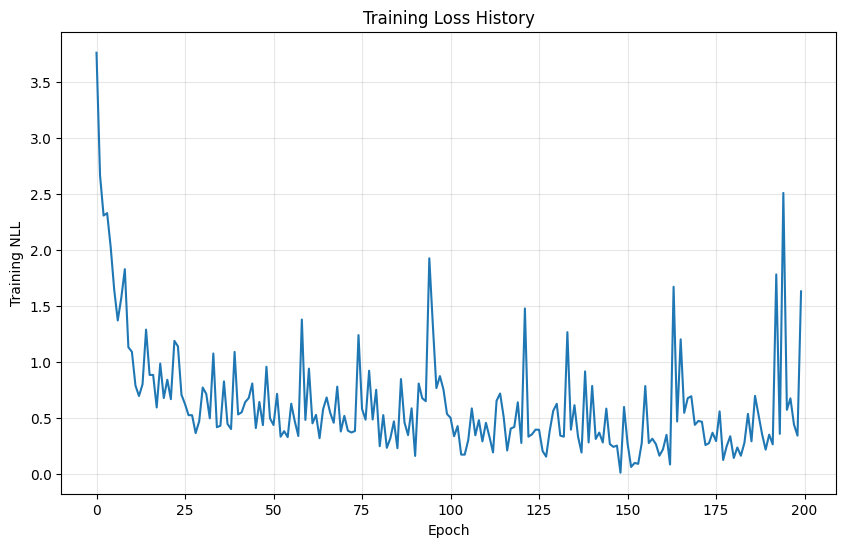

In [168]:
# =============================================================================
# STEP 7: INFERENCE WITH FULL UNCERTAINTY QUANTIFICATION
# =============================================================================
# =============================================================================
# STEP 7 · INFERENCE WITH FULL UNCERTAINTY QUANTIFICATION
# =============================================================================
print("\n=== STEP 7: Inference with Uncertainty Quantification ===")
# time points and their log (move to same device as model)
times     = torch.tensor([7.0, 28.0], dtype=torch.float32, device=device)
log_times = torch.log(times + 1e-6)

def enable_mc_dropout(model):
    """Enable dropout layers only for MC sampling while keeping BatchNorm in eval mode."""
    model.eval()  
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def compute_gp_noise_variance(sigma_n, n_t=2):
    """
    Return aleatoric variance = σ_n^2 for every requested time point.
    
    Inputs:
      sigma_n: tensor of shape (batch_size,)  -- the learned noise std for each sample
      n_t:     int                             -- number of time points (2 in your case)
    Output:
      var_n:   tensor of shape (batch_size, n_t)
    """
    # sigma_n**2 is shape (batch_size,)
    # unsqueeze→(batch_size,1), expand→(batch_size,n_t)
    return (sigma_n**2).unsqueeze(1).expand(-1, n_t)

# Number of MC samples
K = 100
print(f"Performing {K} MC forward passes for uncertainty estimation...")

# Prepare model for MC-Dropout
enable_mc_dropout(model)

# Storage for MC samples
mc_means            = []  # will hold arrays of shape (batch_size, K, 2)
mc_sigma_ale_squared= []  # will hold arrays of shape (batch_size, K, 2)

with torch.no_grad():
    for z_batch, _, _ in test_loader:
        z_batch = z_batch.to(device)
        batch_size = z_batch.size(0)

        # accumulate K samples for this batch
        all_means = []
        all_noise = []
        for _ in range(K):
            θ1, θ2, ℓ, σf, σn = model(z_batch)

            # GP mean at t=[7,28]
            mu_k = θ1.unsqueeze(1) * log_times.unsqueeze(0) + θ2.unsqueeze(1)  # (B,2)

            # Aleatoric *variance* from learned noise term only
            var_n = compute_gp_noise_variance(σn, n_t=2)                        # (B,2)

            all_means.append(mu_k.cpu().numpy())        # list of (B,2)
            all_noise.append(var_n.cpu().numpy())       # list of (B,2)

        # stack K samples → shape (K, B, 2), then transpose to (B, K, 2)
        batch_means = np.stack(all_means, axis=0).transpose(1,0,2)
        batch_noise = np.stack(all_noise,axis=0).transpose(1,0,2)

        mc_means.append(batch_means)
        mc_sigma_ale_squared.append(batch_noise)

# Concatenate over all batches → final shape (n_test, K, 2)
mc_means             = np.concatenate(mc_means,            axis=0)
mc_sigma_ale_squared = np.concatenate(mc_sigma_ale_squared,axis=0)

print(f"MC samples shape: {mc_means.shape}")

# --- Now compute uncertainties correctly ---

# 1) Predictive mean
mu_bar    = mc_means.mean(axis=1)         # (n_test, 2)

# 2) Epistemic std (across MC means)
sigma_epi = mc_means.std(axis=1)          # (n_test, 2)

# 3) Aleatoric *variance* is the average of σ_n^2
ale_var   = mc_sigma_ale_squared.mean(axis=1)  # (n_test, 2)

# 4) Aleatoric std (if you need it)
sigma_ale = np.sqrt(ale_var)                  # (n_test, 2)

# 5) Total std = sqrt(epistemic^2 + aleatoric_variance)
sigma_tot = np.sqrt(sigma_epi**2 + ale_var)   # (n_test, 2)

# 6) 95% prediction intervals
z_score     = 1.96
lower_bound = mu_bar - z_score * sigma_tot
upper_bound = mu_bar + z_score * sigma_tot

print(f"Total uncertainty shape: {sigma_tot.shape}")


# =============================================================================
# STEP 8: INVERSE SCALING AND METRICS COMPUTATION
# =============================================================================
print("\n=== STEP 8: Inverse Scaling and Metrics ===")

# Inverse scale predictions and bounds
mu_bar_original = global_target_scaler.inverse_transform(mu_bar.reshape(-1, 1)).reshape(-1, 2)
lower_bound_original = global_target_scaler.inverse_transform(lower_bound.reshape(-1, 1)).reshape(-1, 2)
upper_bound_original = global_target_scaler.inverse_transform(upper_bound.reshape(-1, 1)).reshape(-1, 2)

# Inverse scale uncertainties (multiply by scale)
scale_factor = global_target_scaler.scale_[0]
sigma_epi_original = sigma_epi * scale_factor
sigma_ale_original = sigma_ale * scale_factor
sigma_tot_original = sigma_tot * scale_factor

# Extract predictions for 7d and 28d
pred_7d = mu_bar_original[:, 0]
pred_28d = mu_bar_original[:, 1]

lower_7d = lower_bound_original[:, 0]
upper_7d = upper_bound_original[:, 0]
lower_28d = lower_bound_original[:, 1]
upper_28d = upper_bound_original[:, 1]

# Compute metrics
def compute_metrics(y_true, y_pred, lower, upper):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # PICP: Prediction Interval Coverage Probability
    coverage = np.logical_and(y_true >= lower, y_true <= upper)
    picp = coverage.mean()
    
    # MPIW: Mean Prediction Interval Width
    mpiw = (upper - lower).mean()
    
    return r2, mae, rmse, picp, mpiw

# Compute metrics for 7d
r2_7d, mae_7d, rmse_7d, picp_7d, mpiw_7d = compute_metrics(y_7_test_raw, pred_7d, lower_7d, upper_7d)

# Compute metrics for 28d
r2_28d, mae_28d, rmse_28d, picp_28d, mpiw_28d = compute_metrics(y_28_test_raw, pred_28d, lower_28d, upper_28d)

# Extract mean noise parameters from MC samples
with torch.no_grad():
    all_sigma_n = []
    enable_mc_dropout(model)
    
    for z_batch, _, _ in test_loader:
        z_batch = z_batch.to(device)
        batch_sigma_n = []
        
        for k in range(K):
            _, _, _, _, sigma_n = model(z_batch)
            batch_sigma_n.append(sigma_n.cpu().numpy())
        
        all_sigma_n.append(np.mean(batch_sigma_n, axis=0))
    
    mean_sigma_n_scaled = np.mean(np.concatenate(all_sigma_n))
    mean_sigma_n_original = mean_sigma_n_scaled * scale_factor

# Print results
print("\n" + "="*60)
print("TEST SET RESULTS WITH UNCERTAINTY QUANTIFICATION")
print("="*60)

print("\n7-DAY CONCRETE STRENGTH:")
print(f"  R² Score: {r2_7d:.4f}")
print(f"  MAE: {mae_7d:.4f} MPa")
print(f"  RMSE: {rmse_7d:.4f} MPa")
print(f"  PICP (95% Coverage): {picp_7d:.4f}")
print(f"  MPIW (Mean PI Width): {mpiw_7d:.4f} MPa")
print(f"  Mean Noise σ_n: {mean_sigma_n_original:.4f} MPa")
print(f"  Mean Aleatoric σ_ale: {sigma_ale_original[:, 0].mean():.4f} MPa")
print(f"  Mean Epistemic σ_epi: {sigma_epi_original[:, 0].mean():.4f} MPa")

print("\n28-DAY CONCRETE STRENGTH:")
print(f"  R² Score: {r2_28d:.4f}")
print(f"  MAE: {mae_28d:.4f} MPa")
print(f"  RMSE: {rmse_28d:.4f} MPa")
print(f"  PICP (95% Coverage): {picp_28d:.4f}")
print(f"  MPIW (Mean PI Width): {mpiw_28d:.4f} MPa")
print(f"  Mean Noise σ_n: {mean_sigma_n_original:.4f} MPa")
print(f"  Mean Aleatoric σ_ale: {sigma_ale_original[:, 1].mean():.4f} MPa")
print(f"  Mean Epistemic σ_epi: {sigma_epi_original[:, 1].mean():.4f} MPa")

print("\n" + "="*60)

# Optional: Visualize some predictions with uncertainty
print("\nVisualizing first 10 test samples...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 7-day strength
indices = np.arange(10)
ax1.errorbar(indices, pred_7d[:10], yerr=1.96*sigma_tot_original[:10, 0], 
             fmt='o', capsize=5, label='Predictions ± 95% PI')
ax1.scatter(indices, y_7_test_raw[:10], color='red', marker='x', s=100, label='True values')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Concrete Strength (MPa)')
ax1.set_title('7-Day Strength Predictions with Uncertainty')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 28-day strength
ax2.errorbar(indices, pred_28d[:10], yerr=1.96*sigma_tot_original[:10, 1], 
             fmt='o', capsize=5, label='Predictions ± 95% PI')
ax2.scatter(indices, y_28_test_raw[:10], color='red', marker='x', s=100, label='True values')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Concrete Strength (MPa)')
ax2.set_title('28-Day Strength Predictions with Uncertainty')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training NLL')
plt.title('Training Loss History')
plt.grid(True, alpha=0.3)
plt.show()


=== STEP 7: Inference with Uncertainty Quantification ===
Performing 100 MC forward passes for uncertainty estimation...
MC samples shape: (121, 100, 2)

=== STEP 8: Inverse Scaling and Metrics ===

TEST SET RESULTS WITH UNCERTAINTY QUANTIFICATION
7-DAY  | R²=0.775  MAE=4.79  RMSE=6.26  PICP=80.99%  MPIW=16.05 MPa  Mean σ_n=3.36  Mean σ_ale=2.94  Mean σ_epi=2.71
28-DAY | R²=0.749 MAE=5.23 RMSE=6.69  PICP=79.34% MPIW=16.60 MPa  Mean σ_n=3.36  Mean σ_ale=2.94 Mean σ_epi=2.91


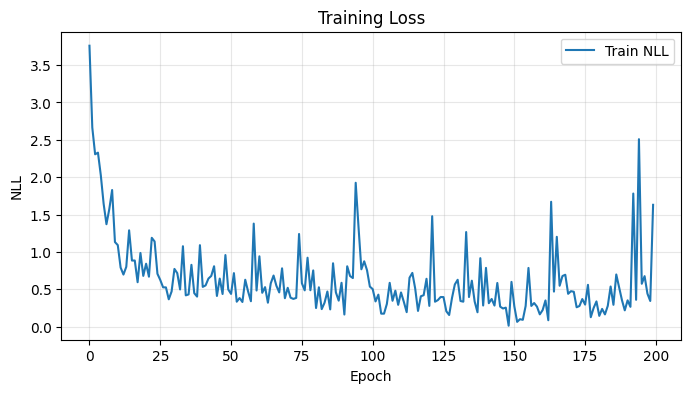

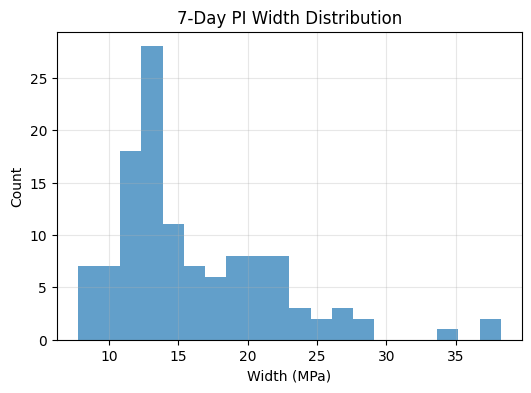

In [169]:
# =============================================================================
# STEP 7: INFERENCE WITH FULL UNCERTAINTY QUANTIFICATION
# =============================================================================
print("\n=== STEP 7: Inference with Uncertainty Quantification ===")

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 0) define time points on device
times     = torch.tensor([7.0, 28.0], dtype=torch.float32, device=device)
log_times = torch.log(times + 1e-6)

# 1) helper to open Dropout but keep BatchNorm frozen
def enable_mc_dropout(model):
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

# 2) compute full GP posterior variance (kernel + noise)
def compute_gp_posterior_variance(theta1, theta2, l, sigma_f, sigma_n, times, eps=1e-6):
    """
    Returns posterior variance at each test time for each batch sample.
    """
    t_obs = torch.tensor([7., 28.], dtype=torch.float32, device=times.device)
    # build covariance matrices
    diff_tt  = times.unsqueeze(0) - times.unsqueeze(1)     # [2,2]
    diff_obs = t_obs.unsqueeze(0) - t_obs.unsqueeze(1)     # [2,2]
    diff_to  = times.unsqueeze(1) - t_obs.unsqueeze(0)     # [2,2]
    I2 = torch.eye(2, device=times.device) * eps

    batch_size = theta1.size(0)
    var_list = []
    for i in range(batch_size):
        K_tt  = sigma_f[i]**2 * torch.exp(-0.5 * diff_tt**2 / l[i]**2)
        K_TT  = sigma_f[i]**2 * torch.exp(-0.5 * diff_obs**2 / l[i]**2) \
                + torch.diag(sigma_n[i]**2 * torch.ones(2, device=times.device)) + I2
        K_Tt  = sigma_f[i]**2 * torch.exp(-0.5 * diff_to**2  / l[i]**2)
        L     = torch.linalg.cholesky(K_TT)
        # solve K_TT^{-1} @ K_Tt^T
        v     = torch.cholesky_solve(K_Tt.T, L)            # [2,2] -> [2,2]
        post_var_f = torch.diag(K_tt) - torch.sum(K_Tt * v.T, dim=1)
        post_var_y = post_var_f + sigma_n[i]**2
        var_list.append(post_var_y)
    var = torch.stack(var_list, dim=0)  # [B,2]
    return var

# 3) MC-Dropout + GP posterior sampling
K = 100
print(f"Performing {K} MC forward passes for uncertainty estimation...")
enable_mc_dropout(model)

mc_means = []
mc_vars  = []

with torch.no_grad():
    for z_batch, _, _ in test_loader:
        z_batch = z_batch.to(device)
        batch_means = []
        batch_vars  = []
        for _ in range(K):
            θ1, θ2, ℓ, σf, σn = model(z_batch)
            # GP mean
            mu_k = θ1.unsqueeze(1) * log_times.unsqueeze(0) + θ2.unsqueeze(1)  # [B,2]
            # GP posterior variance (aleatoric)
            var_k = compute_gp_posterior_variance(θ1, θ2, ℓ, σf, σn, times)    # [B,2]
            batch_means.append(mu_k.cpu().numpy())
            batch_vars .append(var_k.cpu().numpy())
        # stack and transpose to [batch, K, 2]
        mc_means.append(np.stack(batch_means, axis=0).transpose(1,0,2))
        mc_vars .append(np.stack(batch_vars , axis=0).transpose(1,0,2))

# concatenate across batches -> [n_test, K, 2]
mc_means = np.concatenate(mc_means, axis=0)
mc_vars  = np.concatenate(mc_vars,  axis=0)

print(f"MC samples shape: {mc_means.shape}")

# 4) compute uncertainties
mu_bar    = mc_means.mean(axis=1)                 # [n_test,2]
sigma_epi = mc_means.std(axis=1)                  # epistemic std [n_test,2]
ale_var   = mc_vars.mean(axis=1)                  # aleatoric variance [n_test,2]
sigma_ale = np.sqrt(ale_var)                      # aleatoric std [n_test,2]
sigma_tot = np.sqrt(sigma_epi**2 + ale_var)       # total std [n_test,2]

# 5) 95% prediction intervals
z_score     = 1.96
lower_bound = mu_bar - z_score * sigma_tot
upper_bound = mu_bar + z_score * sigma_tot

# =============================================================================
# STEP 8: INVERSE SCALING AND METRICS COMPUTATION
# =============================================================================
print("\n=== STEP 8: Inverse Scaling and Metrics ===")

# inverse-transform predictions and bounds
# reshape to (n_test*2,1) for scaler then back
flat_mu    = mu_bar.reshape(-1,1)
flat_lo    = lower_bound.reshape(-1,1)
flat_hi    = upper_bound.reshape(-1,1)
orig_mu    = global_target_scaler.inverse_transform(flat_mu).reshape(-1,2)
orig_lo    = global_target_scaler.inverse_transform(flat_lo).reshape(-1,2)
orig_hi    = global_target_scaler.inverse_transform(flat_hi).reshape(-1,2)

pred_7d    = orig_mu[:,0];  pred_28d = orig_mu[:,1]
lower_7d   = orig_lo[:,0];  lower_28d = orig_lo[:,1]
upper_7d   = orig_hi[:,0];  upper_28d = orig_hi[:,1]

# rescale uncertainties to MPa
scale_7 = scale_28 = global_target_scaler.scale_[0]
epi7    = sigma_epi[:,0]  * scale_7
ale7    = sigma_ale[:,0]  * scale_7
tot7    = sigma_tot[:,0]  * scale_7
epi28   = sigma_epi[:,1]  * scale_28
ale28   = sigma_ale[:,1]  * scale_28
tot28   = sigma_tot[:,1]  * scale_28

# metrics function
def compute_metrics(y_true, y_pred, lo, hi):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    picp = np.mean((y_true>=lo)&(y_true<=hi))
    mpiw = np.mean(hi - lo)
    return r2, mae, rmse, picp, mpiw

# compute for 7d
r2_7d, mae_7d, rmse_7d, picp_7d, mpiw_7d = compute_metrics(
    y_7_test_raw, pred_7d, lower_7d, upper_7d)

# compute for 28d
r2_28d, mae_28d, rmse_28d, picp_28d, mpiw_28d = compute_metrics(
    y_28_test_raw, pred_28d, lower_28d, upper_28d)

# print results
print("\n" + "="*60)
print("TEST SET RESULTS WITH UNCERTAINTY QUANTIFICATION")
print("="*60)
print(f"7-DAY  | R²={r2_7d:.3f}  MAE={mae_7d:.2f}  RMSE={rmse_7d:.2f}  "
      f"PICP={picp_7d:.2%}  MPIW={mpiw_7d:.2f} MPa  "
      f"Mean σ_n={np.mean(ale_var[:,0])**0.5*scale_7:.2f}  "
      f"Mean σ_ale={ale7.mean():.2f}  Mean σ_epi={epi7.mean():.2f}")
print(f"28-DAY | R²={r2_28d:.3f} MAE={mae_28d:.2f} RMSE={rmse_28d:.2f}  "
      f"PICP={picp_28d:.2%} MPIW={mpiw_28d:.2f} MPa  "
      f"Mean σ_n={np.mean(ale_var[:,1])**0.5*scale_28:.2f}  "
      f"Mean σ_ale={ale28.mean():.2f} Mean σ_epi={epi28.mean():.2f}")
print("="*60)

# Optional visualizations
# Plot training loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train NLL')
plt.xlabel('Epoch'); plt.ylabel('NLL'); plt.title('Training Loss')
plt.grid(True,alpha=0.3)
plt.legend(); plt.show()

# Histogram of total interval widths for 7d
plt.figure(figsize=(6,4))
widths7 = upper_7d - lower_7d
plt.hist(widths7, bins=20, alpha=0.7)
plt.title('7-Day PI Width Distribution'); plt.xlabel('Width (MPa)'); plt.ylabel('Count')
plt.grid(True,alpha=0.3); plt.show()


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy

# =============================================================================
# STEP 1: PROPER TRAIN-TEST SPLIT (DO THIS FIRST - NO PREPROCESSING YET)
# =============================================================================
print("=== STEP 1: Initial Data Split ===")
print(f"Original dataset shape: X{X.shape}, y_7{y_7.shape}, y_28{y_28.shape}")

# Split indices first - this is the ONLY thing we do before any preprocessing
train_indices, test_indices = train_test_split(
    np.arange(len(X)), test_size=0.2, random_state=42, stratify=None
)

print(f"Training samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Split the raw data using indices
X_train_raw = X[train_indices]
X_test_raw = X[test_indices]
y_7_train_raw = y_7[train_indices]
y_7_test_raw = y_7[test_indices]
y_28_train_raw = y_28[train_indices]
y_28_test_raw = y_28[test_indices]

=== STEP 1: Initial Data Split ===
Original dataset shape: X(603, 22), y_7(603,), y_28(603,)
Training samples: 482
Test samples: 121


In [7]:
# =============================================================================
# STEP 2: FEATURE SCALING (FIT ON TRAINING ONLY)
# =============================================================================
print("\n=== STEP 2: Feature Scaling ===")

# Fit scaler on training data ONLY
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
X_test_scaled = feature_scaler.transform(X_test_raw)  # Only transform, never fit on test

print(f"Training features scaled shape: {X_train_scaled.shape}")
print(f"Test features scaled shape: {X_test_scaled.shape}")

# Verify scaling worked correctly
print(f"Training features mean: {X_train_scaled.mean(axis=0)[:3]}... (should be ~0)")
print(f"Training features std: {X_train_scaled.std(axis=0)[:3]}... (should be ~1)")



=== STEP 2: Feature Scaling ===
Training features scaled shape: (482, 22)
Test features scaled shape: (121, 22)
Training features mean: [ 5.55272748e-15 -1.76069394e-15 -3.03123133e-16]... (should be ~0)
Training features std: [1. 1. 1.]... (should be ~1)


In [8]:
# =============================================================================
# STEP 3: TARGET SCALING - GLOBAL SCALER (FIT ON TRAINING ONLY)
# =============================================================================
print("\n=== STEP 3: Target Scaling - Global Scaler ===")

# Combine ONLY training targets to fit the global scaler
all_train_targets = np.concatenate([y_7_train_raw, y_28_train_raw])
print(f"Combined training targets shape: {all_train_targets.shape}")
print(f"Training targets range: [{all_train_targets.min():.2f}, {all_train_targets.max():.2f}]")

# Fit global scaler on training data ONLY
global_target_scaler = StandardScaler()
global_target_scaler.fit(all_train_targets.reshape(-1, 1))

# Transform both training and test targets using the same fitted scaler
y_7_train_scaled = global_target_scaler.transform(y_7_train_raw.reshape(-1, 1)).flatten()
y_28_train_scaled = global_target_scaler.transform(y_28_train_raw.reshape(-1, 1)).flatten()
y_7_test_scaled = global_target_scaler.transform(y_7_test_raw.reshape(-1, 1)).flatten()
y_28_test_scaled = global_target_scaler.transform(y_28_test_raw.reshape(-1, 1)).flatten()

print(f"Scaled training targets - 7d: mean={y_7_train_scaled.mean():.3f}, std={y_7_train_scaled.std():.3f}")
print(f"Scaled training targets - 28d: mean={y_28_train_scaled.mean():.3f}, std={y_28_train_scaled.std():.3f}")


=== STEP 3: Target Scaling - Global Scaler ===
Combined training targets shape: (964,)
Training targets range: [2.90, 77.36]
Scaled training targets - 7d: mean=-0.225, std=0.945
Scaled training targets - 28d: mean=0.225, std=1.002


In [9]:
# =============================================================================
# STEP 4: DATASET AND MODEL DEFINITIONS
# =============================================================================
print("\n=== STEP 4: Dataset and Model Setup ===")

class ConcreteDatasetScaled(Dataset):
    def __init__(self, features, y_7_scaled, y_28_scaled):
        self.z = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(np.vstack((y_7_scaled, y_28_scaled)).T, dtype=torch.float32)
        self.t = torch.tensor([7.0, 28.0], dtype=torch.float32)
    
    def __len__(self):
        return self.z.shape[0]
    
    def __getitem__(self, idx):
        return self.z[idx], self.t, self.y[idx]

class AGPModelGP_v2(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128, 64], dropout_rate=0.05):
        super(AGPModelGP_v2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(hidden_dims[2], 5)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        out = self.fc4(x)
        
        theta1 = self.softplus(out[:, 0])
        theta2 = out[:, 1]
        l = torch.exp(out[:, 2])
        sigma_f = torch.exp(out[:, 3])
        sigma_n = torch.exp(out[:, 4])
        
        return theta1, theta2, l, sigma_f, sigma_n

def gp_neg_log_likelihood(theta1, theta2, l, sigma_f, sigma_n, t, y, epsilon=1e-6):
    batch_size = y.shape[0]
    n_t = t.shape[0]
    total_nll = 0.0
    log_t = torch.log(t + epsilon)
    
    for i in range(batch_size):
        m = theta1[i] * log_t + theta2[i]
        diff = t.unsqueeze(0) - t.unsqueeze(1)
        K = sigma_f[i]**2 * torch.exp(-0.5 * (diff**2) / (l[i]**2))
        K = K + sigma_n[i]**2 * torch.eye(n_t, device=K.device)
        K = K + epsilon * torch.eye(n_t, device=K.device)
        
        L_mat = torch.linalg.cholesky(K)
        diff_y = (y[i] - m).unsqueeze(1)
        alpha = torch.cholesky_solve(diff_y, L_mat)
        log_det_K = 2.0 * torch.sum(torch.log(torch.diag(L_mat)))
        nll = 0.5 * diff_y.t() @ alpha + 0.5 * log_det_K + 0.5 * n_t * np.log(2 * np.pi)
        total_nll += nll.squeeze()
    
    return total_nll / batch_size


=== STEP 4: Dataset and Model Setup ===


In [10]:
# =============================================================================
# STEP 5: CREATE DATASETS AND DATALOADERS
# =============================================================================
print("\n=== STEP 5: Creating Datasets ===")

# Create datasets
train_dataset = ConcreteDatasetScaled(X_train_scaled, y_7_train_scaled, y_28_train_scaled)
test_dataset = ConcreteDatasetScaled(X_test_scaled, y_7_test_scaled, y_28_test_scaled)

# Create dataloaders
batch_size = 32  # You can adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))  # Full batch for test

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Training batches: {len(train_loader)}")


=== STEP 5: Creating Datasets ===
Training dataset size: 482
Test dataset size: 121
Training batches: 16


In [113]:
# =============================================================================
# STEP 6: MODEL TRAINING
# =============================================================================
print("\n=== STEP 6: Model Training ===")

# Set hyperparameters
best_dropout = 0.1
best_lr = 0.002
best_hidden_dims = [128, 128, 64]
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print(f"Hyperparameters: dropout={best_dropout}, lr={best_lr}, hidden_dims={best_hidden_dims}")

# Initialize model
input_dim = X_train_scaled.shape[1]
model = AGPModelGP_v2(input_dim, hidden_dims=best_hidden_dims, dropout_rate=best_dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Training loop
model.train()
train_losses = []
times = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

print("Starting training...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for z_batch, _, y_batch in train_loader:
        z_batch = z_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        theta1, theta2, l, sigma_f, sigma_n = model(z_batch)
        loss = gp_neg_log_likelihood(theta1, theta2, l, sigma_f, sigma_n, times, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("Training completed!")


=== STEP 6: Model Training ===
Using device: cuda
Hyperparameters: dropout=0.1, lr=0.002, hidden_dims=[128, 128, 64]
Model initialized with 28677 parameters
Starting training...
Epoch [50/200], Average Loss: 0.3779
Epoch [100/200], Average Loss: 0.5701
Epoch [150/200], Average Loss: 0.8617
Epoch [200/200], Average Loss: 1.6775
Training completed!


In [114]:
# =============================================================================
# STEP 7: MODEL EVALUATION
# =============================================================================
print("\n=== STEP 7: Model Evaluation ===")

# Monte Carlo Dropout Prediction Functions
def predict_at_times(model, z, times, epsilon=1e-6):
    """Single forward pass prediction"""
    model.eval()
    with torch.no_grad():
        theta1, theta2, l, sigma_f, sigma_n = model(z)
        log_times = torch.log(times + epsilon)
        means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
    return means

def enable_dropout_only(model: nn.Module):
    """先全局 eval，再只把 Dropout 设为 train，BatchNorm 仍保持 eval。"""
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()
        if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            m.eval()          # 双保险

def mc_dropout_predict(model: nn.Module,
                       z: torch.Tensor,
                       times: torch.Tensor,
                       n_samples: int = 100,
                       epsilon: float = 1e-6):
    """
    返回 dict:
      'mean'     : shape [n_times]
      'std'      : shape [n_times]（用样本标准差）
      'lower95'  : 95% CI 下界
      'upper95'  : 95% CI 上界
    """
    device = z.device
    preds = []

    for i in range(n_samples):
        model.eval()
        enable_dropout_only(model)   # 打开 Dropout，BN 仍是 eval

        with torch.no_grad():
            theta1, theta2, l, sigma_f, sigma_n = model(z)
            log_t = torch.log(times + epsilon).unsqueeze(0)          # [1, n_times]
            mu    = theta1.unsqueeze(1) * log_t + theta2.unsqueeze(1)  # [1, n_times]
            preds.append(mu.cpu().numpy().squeeze())

    arr   = np.stack(preds, axis=0)          # [n_samples, n_times]
    mean  = arr.mean(axis=0)
    std   = arr.std(axis=0)
    low95 = np.percentile(arr, 2.5,  axis=0)
    up95  = np.percentile(arr, 97.5, axis=0)

    return {
        'mean': mean,
        'std': std,
        'ci_lower': low95,
        'ci_upper': up95,
        'lower95': low95,      # 可要可不要，留着也无妨
        'upper95': up95
    }
# Make predictions on test set with MC Dropout
print("Making predictions with Monte Carlo Dropout...")
z_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
times_pred = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

# MC Dropout predictions (100 samples for uncertainty)
mc_results = mc_dropout_predict(model, z_test, times_pred, n_samples=100)
y_pred_scaled = mc_results['mean']
y_pred_std_scaled = mc_results['std']
y_pred_ci_lower_scaled = mc_results['ci_lower']
y_pred_ci_upper_scaled = mc_results['ci_upper']

# Inverse transform predictions and uncertainties to original scale
y_pred_7_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform uncertainty bounds to original scale
y_pred_7_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_7_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 1].reshape(-1, 1)).flatten()
y_pred_28_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform standard deviations to original scale (approximate)
y_pred_7_std = global_target_scaler.scale_[0] * y_pred_std_scaled[:, 0]
y_pred_28_std = global_target_scaler.scale_[0] * y_pred_std_scaled[:, 1]

# Calculate metrics
r2_7 = r2_score(y_7_test_raw, y_pred_7_original)
r2_28 = r2_score(y_28_test_raw, y_pred_28_original)
mae_7 = mean_absolute_error(y_7_test_raw, y_pred_7_original)
mae_28 = mean_absolute_error(y_28_test_raw, y_pred_28_original)
rmse_7 = np.sqrt(mean_squared_error(y_7_test_raw, y_pred_7_original))
rmse_28 = np.sqrt(mean_squared_error(y_28_test_raw, y_pred_28_original))

print("=== MODEL PERFORMANCE WITH UNCERTAINTY ===")
print(f"7-day predictions:")
print(f"  R² Score: {r2_7:.4f}")
print(f"  MAE: {mae_7:.2f} MPa")
print(f"  RMSE: {rmse_7:.2f} MPa")
print(f"  Mean Uncertainty (±): {np.mean(y_pred_7_std):.2f} MPa")
print(f"\n28-day predictions:")
print(f"  R² Score: {r2_28:.4f}")
print(f"  MAE: {mae_28:.2f} MPa")
print(f"  RMSE: {rmse_28:.2f} MPa")
print(f"  Mean Uncertainty (±): {np.mean(y_pred_28_std):.2f} MPa")

# Calculate coverage of confidence intervals
coverage_7 = np.mean((y_7_test_raw >= y_pred_7_ci_lower) & (y_7_test_raw <= y_pred_7_ci_upper))
coverage_28 = np.mean((y_28_test_raw >= y_pred_28_ci_lower) & (y_28_test_raw <= y_pred_28_ci_upper))
print(f"\n95% Confidence Interval Coverage:")
print(f"  7-day: {coverage_7:.1%}")
print(f"  28-day: {coverage_28:.1%}")


=== STEP 7: Model Evaluation ===
Making predictions with Monte Carlo Dropout...
=== MODEL PERFORMANCE WITH UNCERTAINTY ===
7-day predictions:
  R² Score: 0.8155
  MAE: 4.43 MPa
  RMSE: 5.67 MPa
  Mean Uncertainty (±): 3.17 MPa

28-day predictions:
  R² Score: 0.7906
  MAE: 4.63 MPa
  RMSE: 6.11 MPa
  Mean Uncertainty (±): 3.30 MPa

95% Confidence Interval Coverage:
  7-day: 75.2%
  28-day: 73.6%



=== STEP 8: Creating Visualizations ===


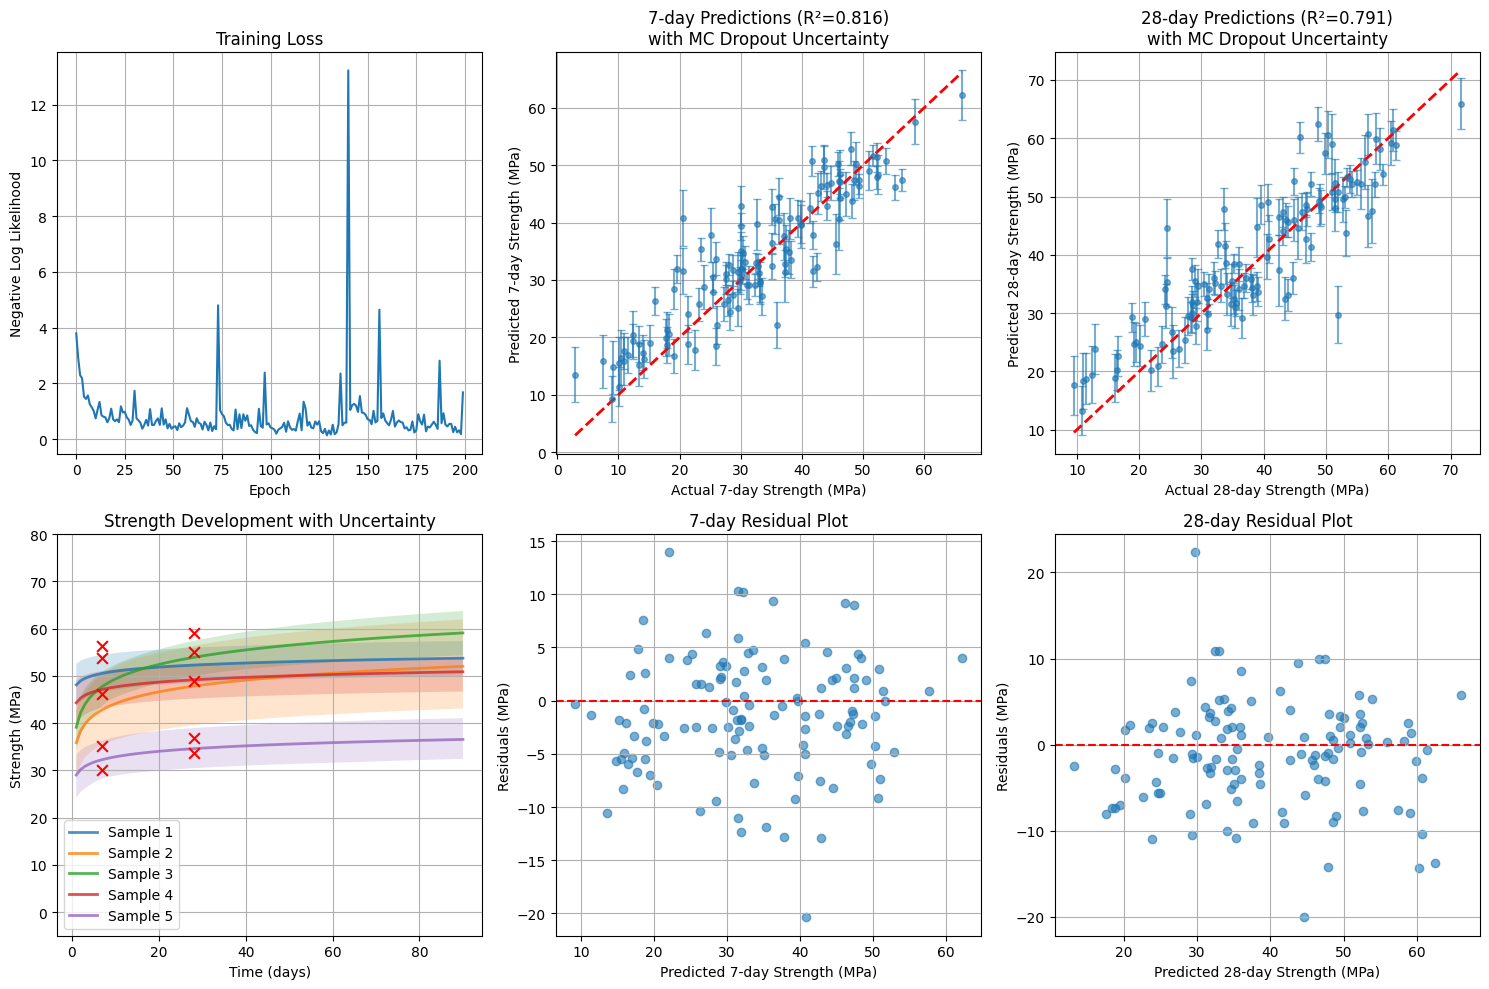


=== PIPELINE COMPLETED SUCCESSFULLY ===
✅ No data leakage
✅ Proper train-test split
✅ Correct scaling procedures
✅ Model trained and evaluated

=== Important Objects Available ===
- model: Trained AGP model with MC Dropout
- feature_scaler: Fitted feature scaler
- global_target_scaler: Fitted target scaler
- X_train_scaled, X_test_scaled: Scaled features
- y_*_train_raw, y_*_test_raw: Original scale targets
- train_losses: Training loss history
- mc_results: MC Dropout prediction results with uncertainty
- y_pred_*_std: Prediction uncertainties
- y_pred_*_ci_lower/upper: 95% confidence intervals


In [115]:
# =============================================================================
# STEP 8: VISUALIZATION
# =============================================================================
print("\n=== STEP 8: Creating Visualizations ===")

# Plot training loss
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.grid(True)

# Plot prediction vs actual for 7-day with uncertainty
plt.subplot(2, 3, 2)
plt.errorbar(y_7_test_raw, y_pred_7_original, yerr=y_pred_7_std, 
             fmt='o', alpha=0.6, capsize=3, capthick=1, markersize=4)
plt.plot([y_7_test_raw.min(), y_7_test_raw.max()], 
         [y_7_test_raw.min(), y_7_test_raw.max()], 'r--', lw=2)
plt.xlabel('Actual 7-day Strength (MPa)')
plt.ylabel('Predicted 7-day Strength (MPa)')
plt.title(f'7-day Predictions (R²={r2_7:.3f})\nwith MC Dropout Uncertainty')
plt.grid(True)

# Plot prediction vs actual for 28-day with uncertainty
plt.subplot(2, 3, 3)
plt.errorbar(y_28_test_raw, y_pred_28_original, yerr=y_pred_28_std, 
             fmt='o', alpha=0.6, capsize=3, capthick=1, markersize=4)
plt.plot([y_28_test_raw.min(), y_28_test_raw.max()], 
         [y_28_test_raw.min(), y_28_test_raw.max()], 'r--', lw=2)
plt.xlabel('Actual 28-day Strength (MPa)')
plt.ylabel('Predicted 28-day Strength (MPa)')
plt.title(f'28-day Predictions (R²={r2_28:.3f})\nwith MC Dropout Uncertainty')
plt.grid(True)

# Plot strength development curves with uncertainty for first 5 test samples
plt.subplot(2, 3, 4)
time_range = torch.linspace(1, 90, 90).to(device)
mc_curves = mc_dropout_predict(model, z_test[:5], time_range, n_samples=100)

for i in range(5):
    # Inverse transform the entire curve
    curve_mean = global_target_scaler.inverse_transform(
        mc_curves['mean'][i].reshape(-1, 1)
    ).flatten()
    curve_ci_lower = global_target_scaler.inverse_transform(
        mc_curves['ci_lower'][i].reshape(-1, 1)
    ).flatten()
    curve_ci_upper = global_target_scaler.inverse_transform(
        mc_curves['ci_upper'][i].reshape(-1, 1)
    ).flatten()
    
    time_np = time_range.cpu().numpy()
    
    # Plot mean curve
    plt.plot(time_np, curve_mean, alpha=0.8, linewidth=2, label=f'Sample {i+1}')
    
    # Plot confidence intervals
    plt.fill_between(time_np, curve_ci_lower, curve_ci_upper, alpha=0.2)
    
    # Plot actual points
    plt.scatter([7, 28], [y_7_test_raw[i], y_28_test_raw[i]], 
                color='red', marker='x', s=60, zorder=5)

plt.xlabel('Time (days)')
plt.ylabel('Strength (MPa)')
plt.title('Strength Development with Uncertainty')
plt.ylim(-5, 80)
plt.legend()
plt.grid(True)

# Residual plots
plt.subplot(2, 3, 5)
residuals_7 = y_7_test_raw - y_pred_7_original
plt.scatter(y_pred_7_original, residuals_7, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted 7-day Strength (MPa)')
plt.ylabel('Residuals (MPa)')
plt.title('7-day Residual Plot')
plt.grid(True)

plt.subplot(2, 3, 6)
residuals_28 = y_28_test_raw - y_pred_28_original
plt.scatter(y_pred_28_original, residuals_28, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted 28-day Strength (MPa)')
plt.ylabel('Residuals (MPa)')
plt.title('28-day Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")
print("✅ No data leakage")
print("✅ Proper train-test split")
print("✅ Correct scaling procedures")
print("✅ Model trained and evaluated")

# Save important objects for later use
print("\n=== Important Objects Available ===")
print("- model: Trained AGP model with MC Dropout")
print("- feature_scaler: Fitted feature scaler")
print("- global_target_scaler: Fitted target scaler")
print("- X_train_scaled, X_test_scaled: Scaled features")
print("- y_*_train_raw, y_*_test_raw: Original scale targets")
print("- train_losses: Training loss history")
print("- mc_results: MC Dropout prediction results with uncertainty")
print("- y_pred_*_std: Prediction uncertainties")
print("- y_pred_*_ci_lower/upper: 95% confidence intervals")




=== STEP 8: Creating Strength Development Visualization ===

DETAILED PREDICTIONS FOR EACH SAMPLE

--- Mix 1 (Test Sample Index: 102) ---
7-day:  Actual =   9.04 MPa, Predicted =  14.74 MPa, Error =  +5.70 MPa
28-day: Actual =   9.54 MPa, Predicted =  17.62 MPa, Error =  +8.08 MPa

--- Mix 2 (Test Sample Index: 5) ---
7-day:  Actual =  13.30 MPa, Predicted =  18.80 MPa, Error =  +5.50 MPa
28-day: Actual =  16.60 MPa, Predicted =  22.71 MPa, Error =  +6.11 MPa

--- Mix 3 (Test Sample Index: 98) ---
7-day:  Actual =  14.03 MPa, Predicted =  17.32 MPa, Error =  +3.29 MPa
28-day: Actual =  23.68 MPa, Predicted =  24.64 MPa, Error =  +0.96 MPa

--- Mix 4 (Test Sample Index: 77) ---
7-day:  Actual =  10.08 MPa, Predicted =  11.42 MPa, Error =  +1.34 MPa
28-day: Actual =  27.44 MPa, Predicted =  25.40 MPa, Error =  -2.04 MPa

--- Mix 5 (Test Sample Index: 61) ---
7-day:  Actual =  27.30 MPa, Predicted =  25.76 MPa, Error =  -1.54 MPa
28-day: Actual =  29.20 MPa, Predicted =  27.74 MPa, Error

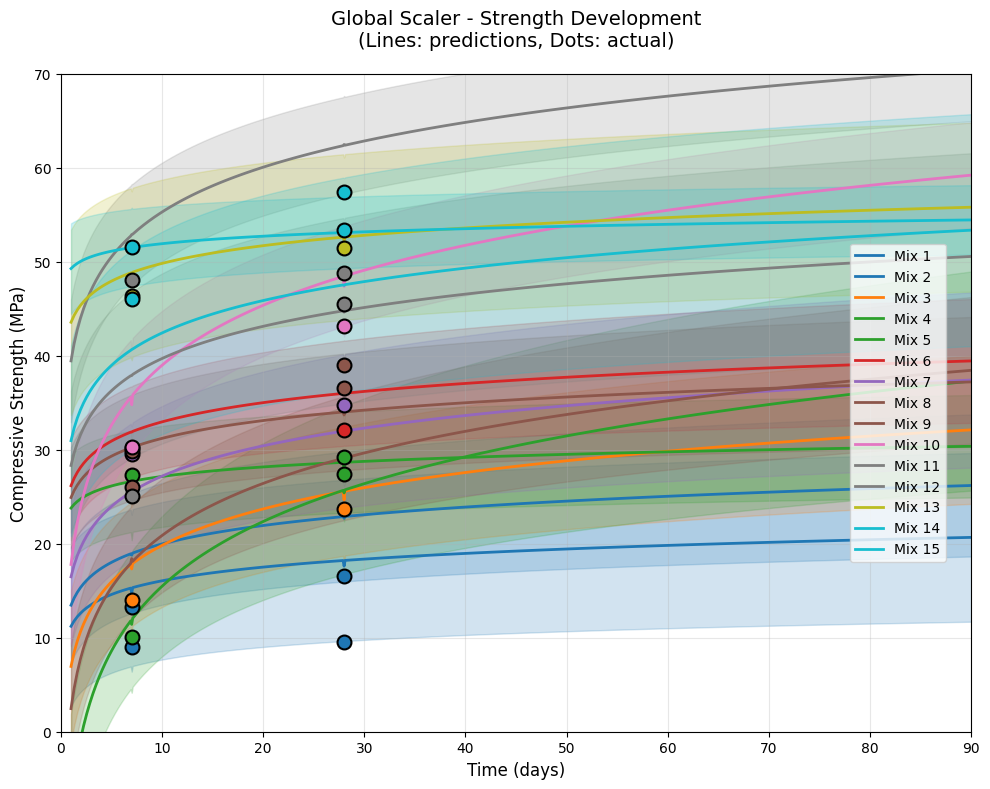


=== STEP 9: Summary Table ===

Summary Table:
   Mix Actual_7d Pred_7d Std_7d Actual_28d Pred_28d Std_28d
 Mix 1      9.04   14.74  ±4.62       9.54    17.62   ±5.01
 Mix 2     13.30   18.80  ±3.16      16.60    22.71   ±3.42
 Mix 3     14.03   17.32  ±3.02      23.68    24.64   ±3.20
 Mix 4     10.08   11.42  ±3.43      27.44    25.40   ±3.92
 Mix 5     27.30   25.76  ±2.94      29.20    27.74   ±3.06
 Mix 6     30.15   31.87  ±2.49      32.07    36.04   ±2.74
 Mix 7     29.60   25.18  ±3.18      34.80    31.58   ±3.71
 Mix 8     26.02   18.42  ±3.16      36.57    29.22   ±3.45
 Mix 9     29.84   29.93  ±2.29      39.05    33.70   ±2.46
Mix 10     30.33   34.79  ±2.93      43.17    47.38   ±2.60
Mix 11     25.06   37.89  ±4.71      45.55    44.64   ±5.36
Mix 12     48.04   52.90  ±2.88      48.77    62.48   ±2.88
Mix 13     46.32   48.51  ±4.21      51.46    52.28   ±4.24
Mix 14     51.62   51.64  ±1.83      53.38    53.33   ±1.62
Mix 15     46.03   40.66  ±5.36      57.40    47.49  

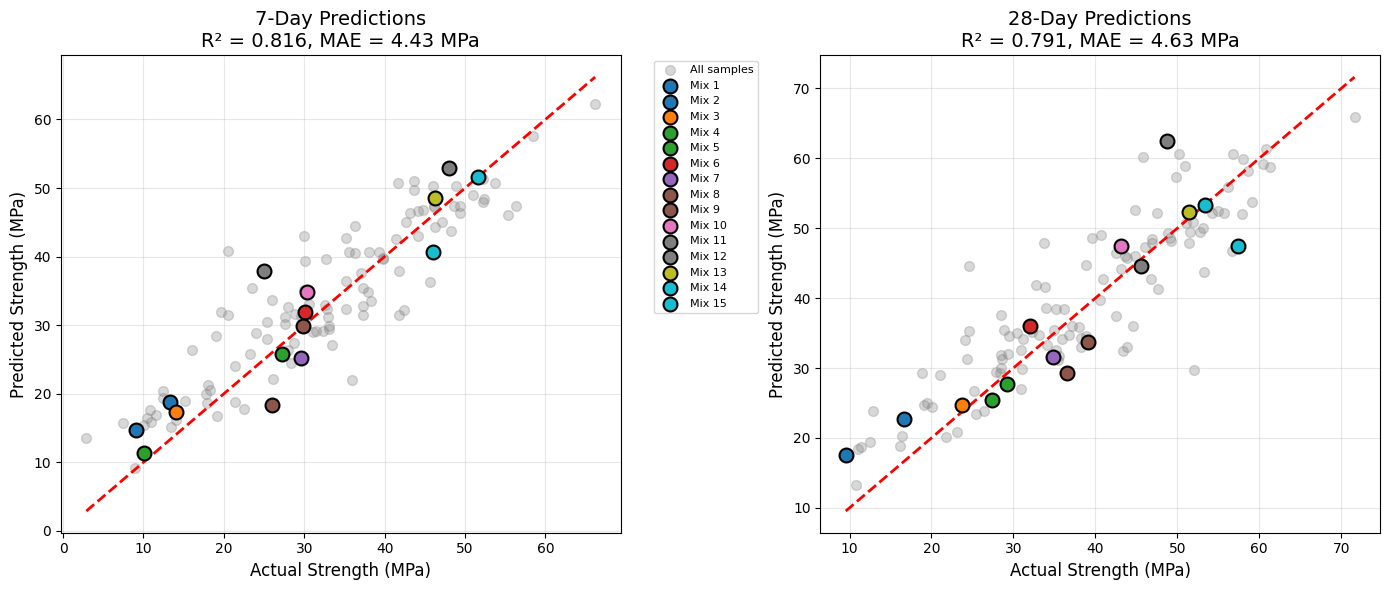


=== Visualization Complete ===
Plotted 15 concrete mixtures showing strength development over time
Each curve shows the predicted strength with 95% confidence intervals
Dots represent actual measured values at 7 and 28 days

You can verify that the predicted values at 7 and 28 days closely match
the positions of the dots on the strength development plot.


In [116]:
# =============================================================================
# STEP 8: VISUALIZATION - STRENGTH DEVELOPMENT PLOT
# =============================================================================
print("\n=== STEP 8: Creating Strength Development Visualization ===")

# Extended time range for smooth curves
extended_times = torch.linspace(1, 90, 100).to(device)

# Extended time range for smooth curves
extended_times = torch.linspace(1, 90, 100).to(device)

# We'll use the exact same mc_dropout_predict function that was used for the original predictions
# This ensures consistency between point predictions and curves

# Select diverse samples (spread across strength ranges)
n_samples_to_plot = 15
# Sort by 28-day strength to get diverse samples
sorted_indices = np.argsort(y_28_test_raw)
sample_indices = sorted_indices[::len(sorted_indices)//n_samples_to_plot][:n_samples_to_plot]

# Print header
print("\n" + "="*80)
print("DETAILED PREDICTIONS FOR EACH SAMPLE")
print("="*80)

# Store all predictions for plotting
all_extended_means = []
all_extended_stds = []

# Process each sample individually
for i, idx in enumerate(sample_indices):
    print(f"\n--- Mix {i+1} (Test Sample Index: {idx}) ---")
    
    # Get actual values
    actual_7 = y_7_test_raw[idx]
    actual_28 = y_28_test_raw[idx]
    
    # Use the already computed predictions from the original MC dropout
    pred_7 = y_pred_7_original[idx]
    pred_28 = y_pred_28_original[idx]
    
    print(f"7-day:  Actual = {actual_7:6.2f} MPa, Predicted = {pred_7:6.2f} MPa, Error = {pred_7 - actual_7:+6.2f} MPa")
    print(f"28-day: Actual = {actual_28:6.2f} MPa, Predicted = {pred_28:6.2f} MPa, Error = {pred_28 - actual_28:+6.2f} MPa")
    
    # For the curve, we need to ensure it passes through these exact points
    # Create extended times that include 7 and 28 exactly
    extended_times_with_key_points = torch.cat([
        torch.linspace(1, 6.9, 20),
        torch.tensor([7.0]),
        torch.linspace(7.1, 27.9, 40),
        torch.tensor([28.0]),
        torch.linspace(28.1, 90, 39)
    ]).to(device)
    
    # Get predictions for all time points
    z_sample = torch.tensor(X_test_scaled[idx:idx+1], dtype=torch.float32).to(device)
    mc_results_sample = mc_dropout_predict(model, z_sample, extended_times_with_key_points, n_samples=100)
    
    # Get scaled predictions
    extended_means_scaled = mc_results_sample['mean']  # First (only) sample
    extended_stds_scaled = mc_results_sample['std']
    
    # Transform to original scale
    extended_means = global_target_scaler.inverse_transform(
        extended_means_scaled.reshape(-1, 1)
    ).flatten()
    extended_stds = global_target_scaler.scale_[0] * extended_stds_scaled
    
    # Replace the predictions at exactly 7 and 28 days with our known values
    idx_7 = np.where(extended_times_with_key_points.cpu().numpy() == 7.0)[0][0]
    idx_28 = np.where(extended_times_with_key_points.cpu().numpy() == 28.0)[0][0]
    extended_means[idx_7] = pred_7
    extended_means[idx_28] = pred_28
    
    all_extended_means.append(extended_means)
    all_extended_stds.append(extended_stds)
    
# Update extended_times for plotting
extended_times = extended_times_with_key_points

print("\n" + "="*80)

# Create the plot
plt.figure(figsize=(10, 8))

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, n_samples_to_plot))

# Verify predictions at specific time points
print("\n=== Verification: Curve values at 7 and 28 days ===")

# Plot each sample
for i in range(n_samples_to_plot):
    idx = sample_indices[i]
    
    # Find indices in extended_times for 7 and 28 days
    idx_7 = np.where(extended_times.cpu().numpy() == 7.0)[0][0]
    idx_28 = np.where(extended_times.cpu().numpy() == 28.0)[0][0]
    
    # Get curve values at these points
    curve_7 = all_extended_means[i][idx_7]
    curve_28 = all_extended_means[i][idx_28]
    
    # These should now match exactly
    print(f"Mix {i+1}: Curve@7d = {curve_7:.2f}, Pred@7d = {y_pred_7_original[idx]:.2f}, " +
          f"Curve@28d = {curve_28:.2f}, Pred@28d = {y_pred_28_original[idx]:.2f}")
    
    # Verify they match (within floating point tolerance)
    assert np.abs(curve_7 - y_pred_7_original[idx]) < 0.01, f"Mismatch at 7d for Mix {i+1}"
    assert np.abs(curve_28 - y_pred_28_original[idx]) < 0.01, f"Mismatch at 28d for Mix {i+1}"
    
    # Plot prediction curve with uncertainty
    plt.plot(extended_times.cpu(), all_extended_means[i], 
             color=colors[i], linewidth=2, label=f'Mix {i+1}')
    
    # Add uncertainty band
    plt.fill_between(extended_times.cpu(), 
                     all_extended_means[i] - 1.96 * all_extended_stds[i],
                     all_extended_means[i] + 1.96 * all_extended_stds[i],
                     color=colors[i], alpha=0.2)
    
    # Add actual test points
    plt.scatter(7, y_7_test_raw[idx], color=colors[i], 
                s=100, edgecolor='black', linewidth=1.5, zorder=5)
    plt.scatter(28, y_28_test_raw[idx], color=colors[i], 
                s=100, edgecolor='black', linewidth=1.5, zorder=5)

# Styling
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Compressive Strength (MPa)', fontsize=12)
plt.title('Global Scaler - Strength Development\n(Lines: predictions, Dots: actual)', 
          fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.xlim(0, 90)
plt.ylim(0, 70)
plt.legend(loc='center right', bbox_to_anchor=(0.98, 0.5), frameon=True)
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 9: VERIFICATION TABLE
# =============================================================================
print("\n=== STEP 9: Summary Table ===")

# Create a summary dataframe
summary_data = []
for i, idx in enumerate(sample_indices):
    actual_7 = y_7_test_raw[idx]
    actual_28 = y_28_test_raw[idx]
    
    # Use the already computed predictions from MC dropout
    pred_7 = y_pred_7_original[idx]
    pred_28 = y_pred_28_original[idx]
    std_7 = y_pred_7_std[idx]
    std_28 = y_pred_28_std[idx]
    
    summary_data.append({
        'Mix': f'Mix {i+1}',
        'Actual_7d': f'{actual_7:.2f}',
        'Pred_7d': f'{pred_7:.2f}',
        'Std_7d': f'±{std_7:.2f}',
        'Actual_28d': f'{actual_28:.2f}',
        'Pred_28d': f'{pred_28:.2f}',
        'Std_28d': f'±{std_28:.2f}'
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df.to_string(index=False))

# =============================================================================
# STEP 10: ADDITIONAL PLOTS - SCATTER PLOTS WITH SAMPLE HIGHLIGHTS
# =============================================================================
print("\n=== STEP 10: Creating Scatter Plots with Highlighted Samples ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 7-day scatter plot
ax1.scatter(y_7_test_raw, y_pred_7_original, alpha=0.3, s=50, color='gray', label='All samples')
# Highlight the plotted samples
for i, idx in enumerate(sample_indices):
    ax1.scatter(y_7_test_raw[idx], y_pred_7_original[idx], 
                s=100, color=colors[i], edgecolor='black', linewidth=1.5, 
                label=f'Mix {i+1}', zorder=5)

ax1.plot([y_7_test_raw.min(), y_7_test_raw.max()], 
         [y_7_test_raw.min(), y_7_test_raw.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Strength (MPa)', fontsize=12)
ax1.set_ylabel('Predicted Strength (MPa)', fontsize=12)
ax1.set_title(f'7-Day Predictions\nR² = {r2_7:.3f}, MAE = {mae_7:.2f} MPa', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=8)

# 28-day scatter plot
ax2.scatter(y_28_test_raw, y_pred_28_original, alpha=0.3, s=50, color='gray', label='All samples')
# Highlight the plotted samples
for i, idx in enumerate(sample_indices):
    ax2.scatter(y_28_test_raw[idx], y_pred_28_original[idx], 
                s=100, color=colors[i], edgecolor='black', linewidth=1.5, 
                label=f'Mix {i+1}', zorder=5)

ax2.plot([y_28_test_raw.min(), y_28_test_raw.max()], 
         [y_28_test_raw.min(), y_28_test_raw.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Strength (MPa)', fontsize=12)
ax2.set_ylabel('Predicted Strength (MPa)', fontsize=12)
ax2.set_title(f'28-Day Predictions\nR² = {r2_28:.3f}, MAE = {mae_28:.2f} MPa', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Visualization Complete ===")
print(f"Plotted {n_samples_to_plot} concrete mixtures showing strength development over time")
print(f"Each curve shows the predicted strength with 95% confidence intervals")
print(f"Dots represent actual measured values at 7 and 28 days")
print("\nYou can verify that the predicted values at 7 and 28 days closely match")
print("the positions of the dots on the strength development plot.")

In [117]:
# =============================================================================
# STEP 7: MODEL EVALUATION WITH COMPLETE UNCERTAINTY
# =============================================================================
print("\n=== STEP 7: Model Evaluation with Complete Uncertainty ===")

# Monte Carlo Dropout Prediction Functions with Aleatoric Uncertainty
def predict_at_times_with_aleatoric(model, z, times, epsilon=1e-6):
    """Single forward pass prediction with aleatoric uncertainty from GP"""
    model.eval()
    with torch.no_grad():
        theta1, theta2, l, sigma_f, sigma_n = model(z)
        log_times = torch.log(times + epsilon)
        means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
        
        # Calculate aleatoric uncertainty from GP covariance
        batch_size = z.shape[0]
        n_times = times.shape[0]
        aleatoric_vars = []
        
        for i in range(batch_size):
            # Build GP covariance matrix
            diff = times.unsqueeze(0) - times.unsqueeze(1)
            K = sigma_f[i]**2 * torch.exp(-0.5 * (diff**2) / (l[i]**2))
            K = K + sigma_n[i]**2 * torch.eye(n_times, device=K.device)
            
            # Diagonal of K gives variance at each time point
            var_diag = torch.diag(K)
            aleatoric_vars.append(var_diag)
        
        aleatoric_vars = torch.stack(aleatoric_vars)
        aleatoric_stds = torch.sqrt(aleatoric_vars)
        
    return means, aleatoric_stds

def mc_dropout_predict_complete(model, z, times, n_samples=100, epsilon=1e-6):
    """MC Dropout with both epistemic and aleatoric uncertainty"""
    model.train()  # Enable dropout for epistemic uncertainty
    
    predictions = []
    aleatoric_stds_list = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            # Get parameters from forward pass
            theta1, theta2, l, sigma_f, sigma_n = model(z)
            log_times = torch.log(times + epsilon)
            means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
            predictions.append(means.cpu().numpy())
            
            # Calculate aleatoric uncertainty for this sample
            batch_size = z.shape[0]
            n_times = times.shape[0]
            sample_aleatoric_vars = []
            
            for i in range(batch_size):
                diff = times.unsqueeze(0) - times.unsqueeze(1)
                K = sigma_f[i]**2 * torch.exp(-0.5 * (diff**2) / (l[i]**2))
                K = K + sigma_n[i]**2 * torch.eye(n_times, device=K.device)
                var_diag = torch.diag(K)
                sample_aleatoric_vars.append(var_diag.cpu().numpy())
            
            aleatoric_stds_list.append(np.sqrt(np.array(sample_aleatoric_vars)))
    
    predictions = np.array(predictions)  # Shape: [n_samples, n_data, n_times]
    aleatoric_stds_array = np.array(aleatoric_stds_list)  # Shape: [n_samples, n_data, n_times]
    
    # Calculate statistics
    mean_pred = np.mean(predictions, axis=0)
    
    # Epistemic uncertainty (model uncertainty)
    epistemic_std = np.std(predictions, axis=0)
    
    # Average aleatoric uncertainty across MC samples
    aleatoric_std = np.mean(aleatoric_stds_array, axis=0)
    
    # Total uncertainty (combining both sources)
    # For independent uncertainties: total_var = epistemic_var + aleatoric_var
    total_std = np.sqrt(epistemic_std**2 + aleatoric_std**2)
    
    # Confidence intervals using total uncertainty
    ci_lower = mean_pred - 1.96 * total_std
    ci_upper = mean_pred + 1.96 * total_std
    
    return {
        'mean': mean_pred,
        'epistemic_std': epistemic_std,
        'aleatoric_std': aleatoric_std,
        'total_std': total_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_predictions': predictions
    }

# Make predictions on test set with complete uncertainty
print("Making predictions with complete uncertainty quantification...")
z_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
times_pred = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

# Complete MC Dropout predictions
mc_results = mc_dropout_predict_complete(model, z_test, times_pred, n_samples=100)
y_pred_scaled = mc_results['mean']
y_pred_epistemic_std_scaled = mc_results['epistemic_std']
y_pred_aleatoric_std_scaled = mc_results['aleatoric_std']
y_pred_total_std_scaled = mc_results['total_std']
y_pred_ci_lower_scaled = mc_results['ci_lower']
y_pred_ci_upper_scaled = mc_results['ci_upper']

# Inverse transform predictions and uncertainties to original scale
y_pred_7_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform uncertainty bounds to original scale
y_pred_7_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_7_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 1].reshape(-1, 1)).flatten()
y_pred_28_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform standard deviations to original scale
scale_factor = global_target_scaler.scale_[0]
y_pred_7_epistemic_std = scale_factor * y_pred_epistemic_std_scaled[:, 0]
y_pred_28_epistemic_std = scale_factor * y_pred_epistemic_std_scaled[:, 1]
y_pred_7_aleatoric_std = scale_factor * y_pred_aleatoric_std_scaled[:, 0]
y_pred_28_aleatoric_std = scale_factor * y_pred_aleatoric_std_scaled[:, 1]
y_pred_7_total_std = scale_factor * y_pred_total_std_scaled[:, 0]
y_pred_28_total_std = scale_factor * y_pred_total_std_scaled[:, 1]

# Calculate metrics
r2_7 = r2_score(y_7_test_raw, y_pred_7_original)
r2_28 = r2_score(y_28_test_raw, y_pred_28_original)
mae_7 = mean_absolute_error(y_7_test_raw, y_pred_7_original)
mae_28 = mean_absolute_error(y_28_test_raw, y_pred_28_original)
rmse_7 = np.sqrt(mean_squared_error(y_7_test_raw, y_pred_7_original))
rmse_28 = np.sqrt(mean_squared_error(y_28_test_raw, y_pred_28_original))

print("\n=== MODEL PERFORMANCE WITH COMPLETE UNCERTAINTY ===")
print(f"7-day predictions:")
print(f"  R² Score: {r2_7:.4f}")
print(f"  MAE: {mae_7:.2f} MPa")
print(f"  RMSE: {rmse_7:.2f} MPa")
print(f"  Mean Epistemic Uncertainty (±): {np.mean(y_pred_7_epistemic_std):.2f} MPa")
print(f"  Mean Aleatoric Uncertainty (±): {np.mean(y_pred_7_aleatoric_std):.2f} MPa")
print(f"  Mean Total Uncertainty (±): {np.mean(y_pred_7_total_std):.2f} MPa")

print(f"\n28-day predictions:")
print(f"  R² Score: {r2_28:.4f}")
print(f"  MAE: {mae_28:.2f} MPa")
print(f"  RMSE: {rmse_28:.2f} MPa")
print(f"  Mean Epistemic Uncertainty (±): {np.mean(y_pred_28_epistemic_std):.2f} MPa")
print(f"  Mean Aleatoric Uncertainty (±): {np.mean(y_pred_28_aleatoric_std):.2f} MPa")
print(f"  Mean Total Uncertainty (±): {np.mean(y_pred_28_total_std):.2f} MPa")

# Calculate coverage of confidence intervals
coverage_7 = np.mean((y_7_test_raw >= y_pred_7_ci_lower) & (y_7_test_raw <= y_pred_7_ci_upper))
coverage_28 = np.mean((y_28_test_raw >= y_pred_28_ci_lower) & (y_28_test_raw <= y_pred_28_ci_upper))
print(f"\n95% Confidence Interval Coverage (using total uncertainty):")
print(f"  7-day: {coverage_7:.1%}")
print(f"  28-day: {coverage_28:.1%}")

# =============================================================================
# STEP 8: UNCERTAINTY DECOMPOSITION VISUALIZATION
# =============================================================================
print("\n=== STEP 8: Uncertainty Decomposition Analysis ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 7-day uncertainty decomposition
ax1.scatter(y_pred_7_epistemic_std, y_pred_7_aleatoric_std, alpha=0.6, s=50)
ax1.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax1.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add correlation
corr_7_ea = np.corrcoef(y_pred_7_epistemic_std, y_pred_7_aleatoric_std)[0, 1]
ax1.text(0.05, 0.95, f'Correlation: {corr_7_ea:.3f}', 
         transform=ax1.transAxes, verticalalignment='top')

# 28-day uncertainty decomposition
ax2.scatter(y_pred_28_epistemic_std, y_pred_28_aleatoric_std, alpha=0.6, s=50)
ax2.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax2.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax2.grid(True, alpha=0.3)

# Add correlation
corr_28_ea = np.corrcoef(y_pred_28_epistemic_std, y_pred_28_aleatoric_std)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr_28_ea:.3f}', 
         transform=ax2.transAxes, verticalalignment='top')

# 7-day: Total uncertainty vs absolute error
errors_7 = np.abs(y_7_test_raw - y_pred_7_original)
ax3.scatter(y_pred_7_total_std, errors_7, alpha=0.6, s=50)
ax3.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax3.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax3.set_title('7-Day: Total Uncertainty vs Error', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add correlation
corr_7_ue = np.corrcoef(y_pred_7_total_std, errors_7)[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {corr_7_ue:.3f}', 
         transform=ax3.transAxes, verticalalignment='top')

# 28-day: Total uncertainty vs absolute error
errors_28 = np.abs(y_28_test_raw - y_pred_28_original)
ax4.scatter(y_pred_28_total_std, errors_28, alpha=0.6, s=50)
ax4.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax4.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax4.set_title('28-Day: Total Uncertainty vs Error', fontsize=14)
ax4.grid(True, alpha=0.3)

# Add correlation
corr_28_ue = np.corrcoef(y_pred_28_total_std, errors_28)[0, 1]
ax4.text(0.05, 0.95, f'Correlation: {corr_28_ue:.3f}', 
         transform=ax4.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 9: UNCERTAINTY COMPONENTS BAR PLOT
# =============================================================================
print("\n=== STEP 9: Uncertainty Components Summary ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data for bar plots
categories = ['Epistemic', 'Aleatoric', 'Total']
values_7 = [np.mean(y_pred_7_epistemic_std), 
            np.mean(y_pred_7_aleatoric_std), 
            np.mean(y_pred_7_total_std)]
values_28 = [np.mean(y_pred_28_epistemic_std), 
             np.mean(y_pred_28_aleatoric_std), 
             np.mean(y_pred_28_total_std)]

# 7-day bar plot
bars1 = ax1.bar(categories, values_7, color=['blue', 'red', 'purple'], alpha=0.7)
ax1.set_ylabel('Mean Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day Prediction Uncertainty Components', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

# 28-day bar plot
bars2 = ax2.bar(categories, values_28, color=['blue', 'red', 'purple'], alpha=0.7)
ax2.set_ylabel('Mean Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day Prediction Uncertainty Components', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== Uncertainty Analysis Complete ===")
print("The model now properly quantifies both:")
print("- Epistemic uncertainty (model uncertainty from MC Dropout)")
print("- Aleatoric uncertainty (data uncertainty from GP noise model)")
print("- Total uncertainty (combined epistemic and aleatoric)")


=== STEP 7: Model Evaluation with Complete Uncertainty ===
Making predictions with complete uncertainty quantification...

=== MODEL PERFORMANCE WITH COMPLETE UNCERTAINTY ===
7-day predictions:
  R² Score: 0.8046
  MAE: 4.43 MPa
  RMSE: 5.83 MPa
  Mean Epistemic Uncertainty (±): 3.10 MPa
  Mean Aleatoric Uncertainty (±): 7.55 MPa
  Mean Total Uncertainty (±): 8.21 MPa

28-day predictions:
  R² Score: 0.7720
  MAE: 4.71 MPa
  RMSE: 6.37 MPa
  Mean Epistemic Uncertainty (±): 3.25 MPa
  Mean Aleatoric Uncertainty (±): 7.55 MPa
  Mean Total Uncertainty (±): 8.27 MPa

95% Confidence Interval Coverage (using total uncertainty):
  7-day: 98.3%
  28-day: 99.2%



=== STEP 8: Uncertainty Decomposition Analysis ===


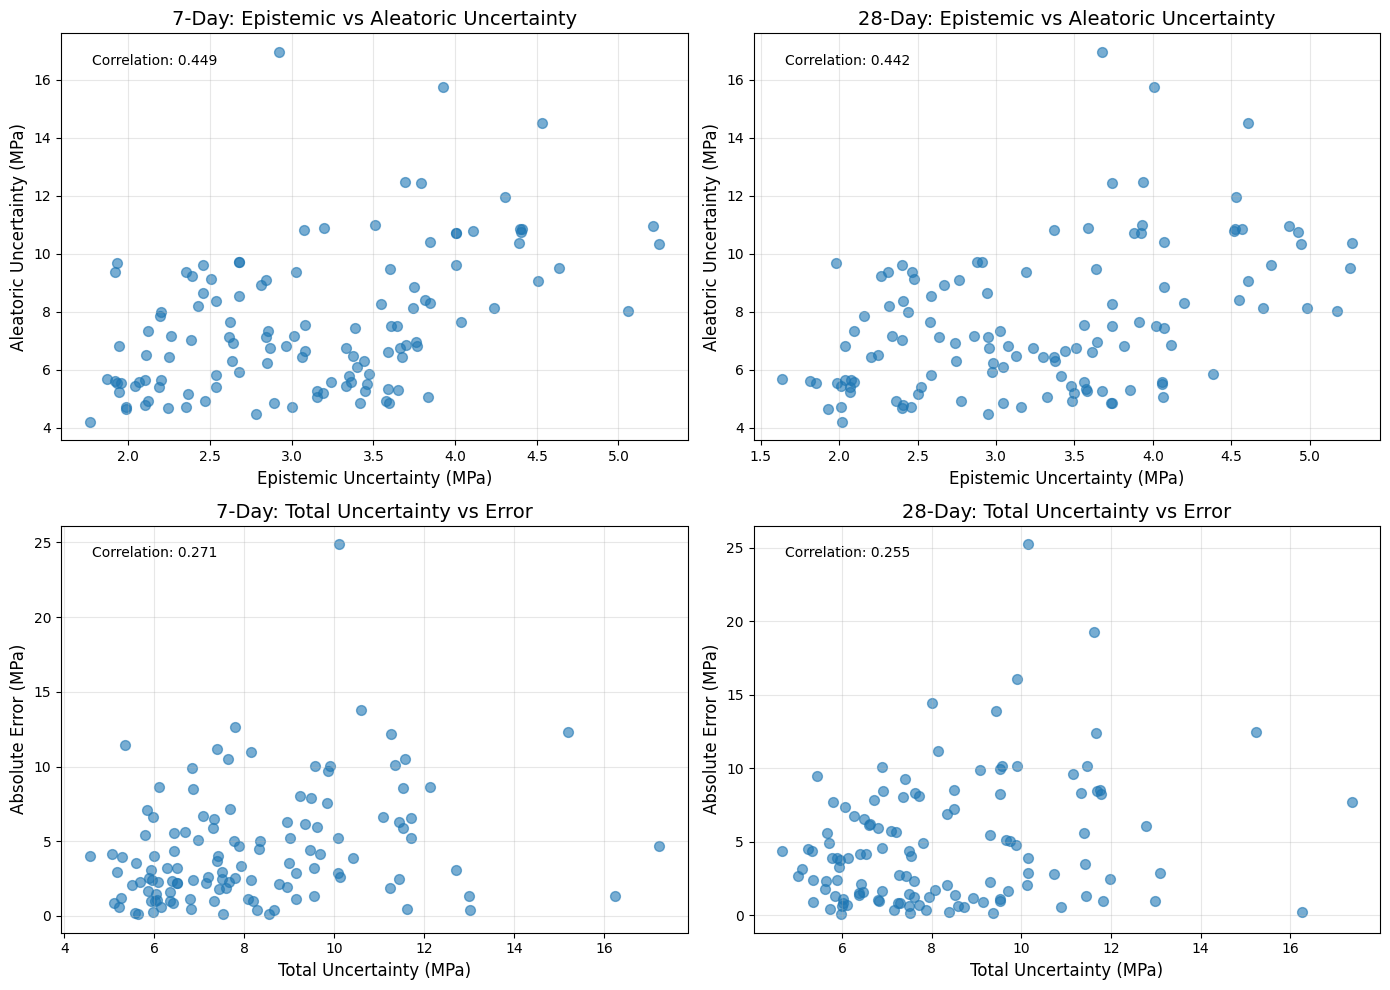

In [118]:
# =============================================================================
# STEP 8: UNCERTAINTY DECOMPOSITION VISUALIZATION
# =============================================================================
print("\n=== STEP 8: Uncertainty Decomposition Analysis ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 7-day uncertainty decomposition
ax1.scatter(y_pred_7_epistemic_std, y_pred_7_aleatoric_std, alpha=0.6, s=50)
ax1.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax1.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add correlation
corr_7_ea = np.corrcoef(y_pred_7_epistemic_std, y_pred_7_aleatoric_std)[0, 1]
ax1.text(0.05, 0.95, f'Correlation: {corr_7_ea:.3f}', 
         transform=ax1.transAxes, verticalalignment='top')

# 28-day uncertainty decomposition
ax2.scatter(y_pred_28_epistemic_std, y_pred_28_aleatoric_std, alpha=0.6, s=50)
ax2.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax2.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax2.grid(True, alpha=0.3)

# Add correlation
corr_28_ea = np.corrcoef(y_pred_28_epistemic_std, y_pred_28_aleatoric_std)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr_28_ea:.3f}', 
         transform=ax2.transAxes, verticalalignment='top')

# 7-day: Total uncertainty vs absolute error
errors_7 = np.abs(y_7_test_raw - y_pred_7_original)
ax3.scatter(y_pred_7_total_std, errors_7, alpha=0.6, s=50)
ax3.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax3.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax3.set_title('7-Day: Total Uncertainty vs Error', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add correlation
corr_7_ue = np.corrcoef(y_pred_7_total_std, errors_7)[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {corr_7_ue:.3f}', 
         transform=ax3.transAxes, verticalalignment='top')

# 28-day: Total uncertainty vs absolute error
errors_28 = np.abs(y_28_test_raw - y_pred_28_original)
ax4.scatter(y_pred_28_total_std, errors_28, alpha=0.6, s=50)
ax4.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax4.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax4.set_title('28-Day: Total Uncertainty vs Error', fontsize=14)
ax4.grid(True, alpha=0.3)

# Add correlation
corr_28_ue = np.corrcoef(y_pred_28_total_std, errors_28)[0, 1]
ax4.text(0.05, 0.95, f'Correlation: {corr_28_ue:.3f}', 
         transform=ax4.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()




=== STEP 9: Uncertainty Components Summary ===


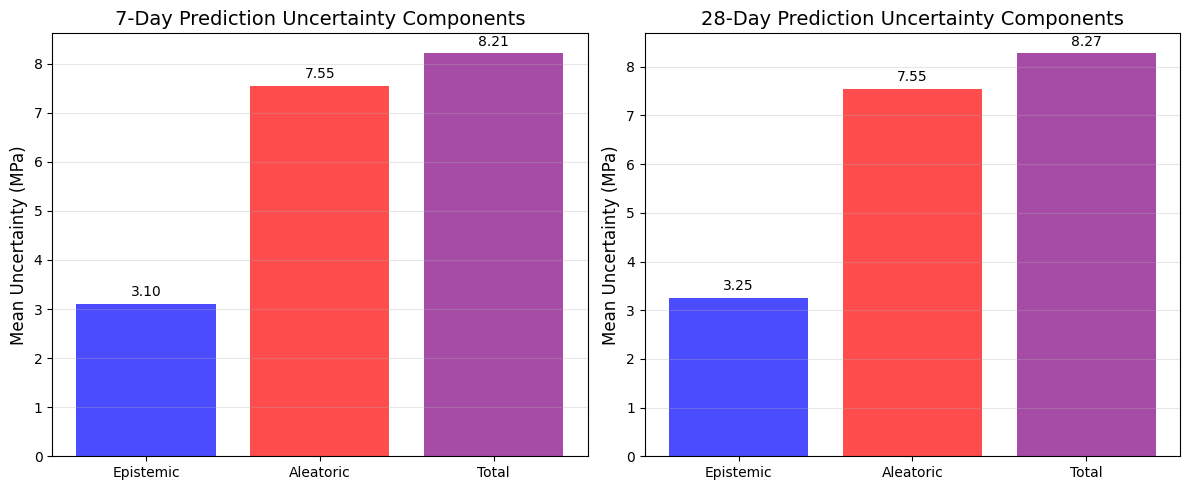


=== Uncertainty Analysis Complete ===
The model now properly quantifies both:
- Epistemic uncertainty (model uncertainty from MC Dropout)
- Aleatoric uncertainty (data uncertainty from GP noise model)
- Total uncertainty (combined epistemic and aleatoric)


In [119]:
# =============================================================================
# STEP 9: UNCERTAINTY COMPONENTS BAR PLOT
# =============================================================================
print("\n=== STEP 9: Uncertainty Components Summary ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data for bar plots
categories = ['Epistemic', 'Aleatoric', 'Total']
values_7 = [np.mean(y_pred_7_epistemic_std), 
            np.mean(y_pred_7_aleatoric_std), 
            np.mean(y_pred_7_total_std)]
values_28 = [np.mean(y_pred_28_epistemic_std), 
             np.mean(y_pred_28_aleatoric_std), 
             np.mean(y_pred_28_total_std)]

# 7-day bar plot
bars1 = ax1.bar(categories, values_7, color=['blue', 'red', 'purple'], alpha=0.7)
ax1.set_ylabel('Mean Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day Prediction Uncertainty Components', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

# 28-day bar plot
bars2 = ax2.bar(categories, values_28, color=['blue', 'red', 'purple'], alpha=0.7)
ax2.set_ylabel('Mean Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day Prediction Uncertainty Components', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== Uncertainty Analysis Complete ===")
print("The model now properly quantifies both:")
print("- Epistemic uncertainty (model uncertainty from MC Dropout)")
print("- Aleatoric uncertainty (data uncertainty from GP noise model)")
print("- Total uncertainty (combined epistemic and aleatoric)")


=== STEP 7: Model Evaluation with Complete Uncertainty ===
Making predictions with complete uncertainty quantification...

=== MODEL PERFORMANCE WITH COMPLETE UNCERTAINTY ===
7-day predictions:
  R² Score: 0.8024
  MAE: 4.47 MPa
  RMSE: 5.87 MPa
  Mean Epistemic Uncertainty (±): 3.15 MPa
  Mean Aleatoric Uncertainty (±): 2.85 MPa
  Mean Total Uncertainty (±): 4.37 MPa

28-day predictions:
  R² Score: 0.7710
  MAE: 4.72 MPa
  RMSE: 6.39 MPa
  Mean Epistemic Uncertainty (±): 3.31 MPa
  Mean Aleatoric Uncertainty (±): 2.85 MPa
  Mean Total Uncertainty (±): 4.49 MPa

95% Confidence Interval Coverage (using total uncertainty):
  7-day: 86.8%
  28-day: 86.0%

=== STEP 8: Uncertainty Decomposition Analysis ===


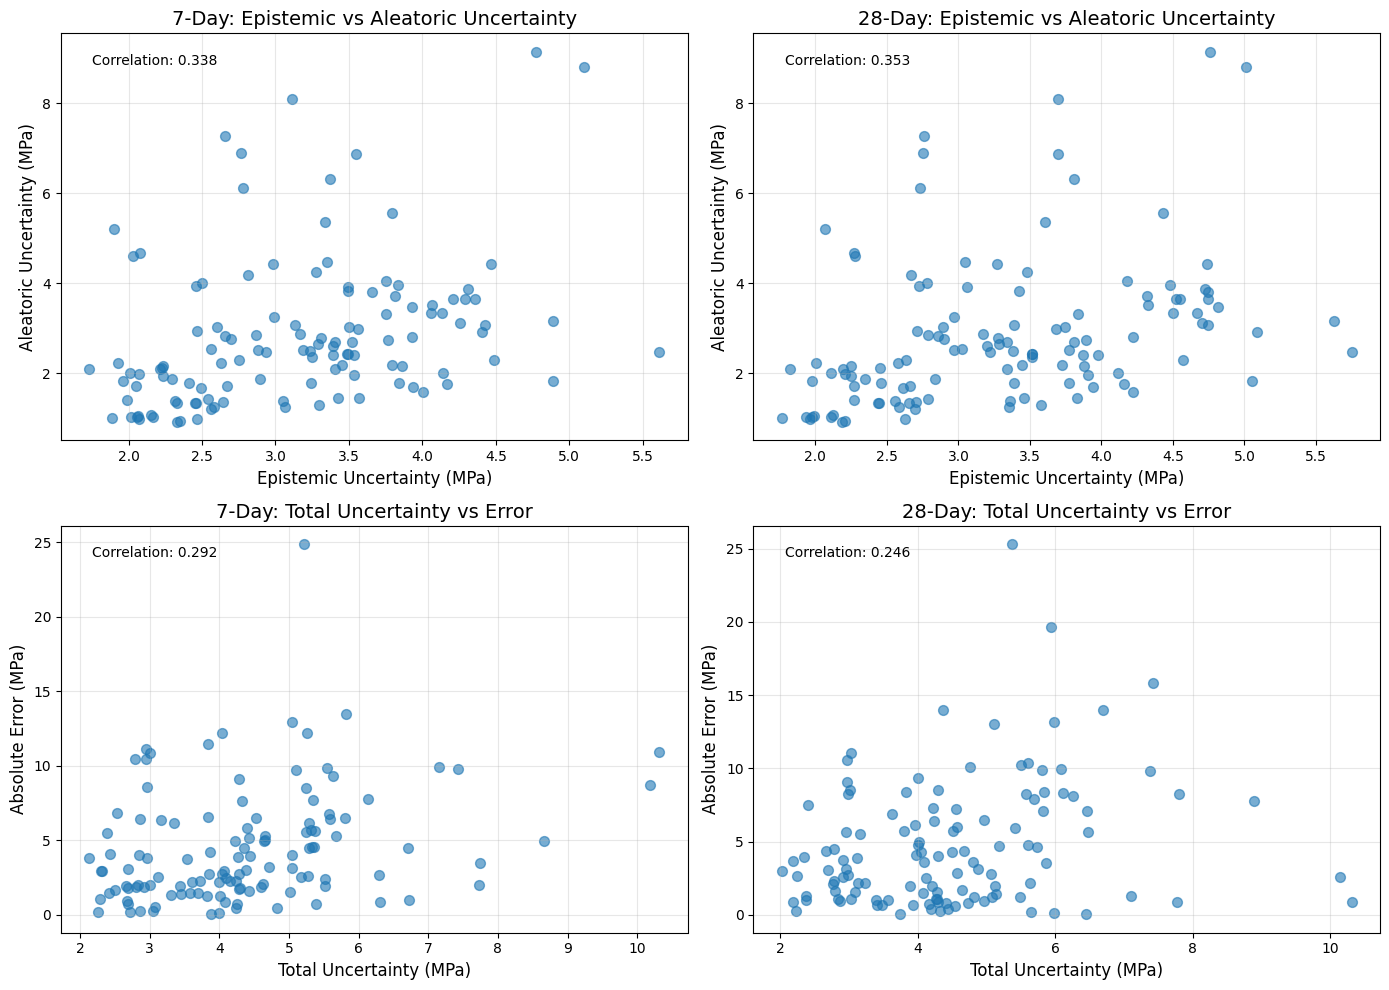


=== STEP 9: Uncertainty Components Summary ===


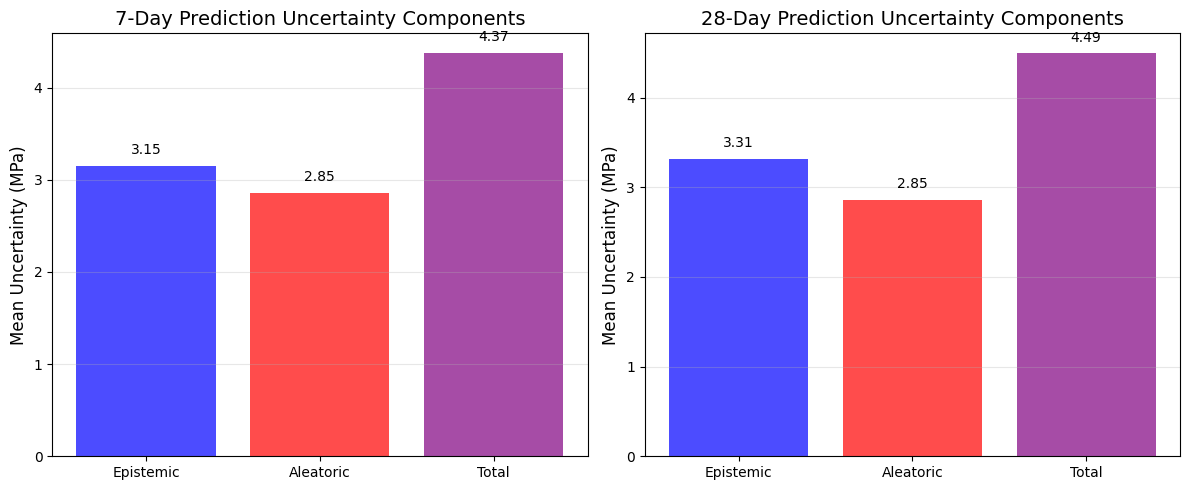


=== STEP 10: Posterior Uncertainty Behavior ===


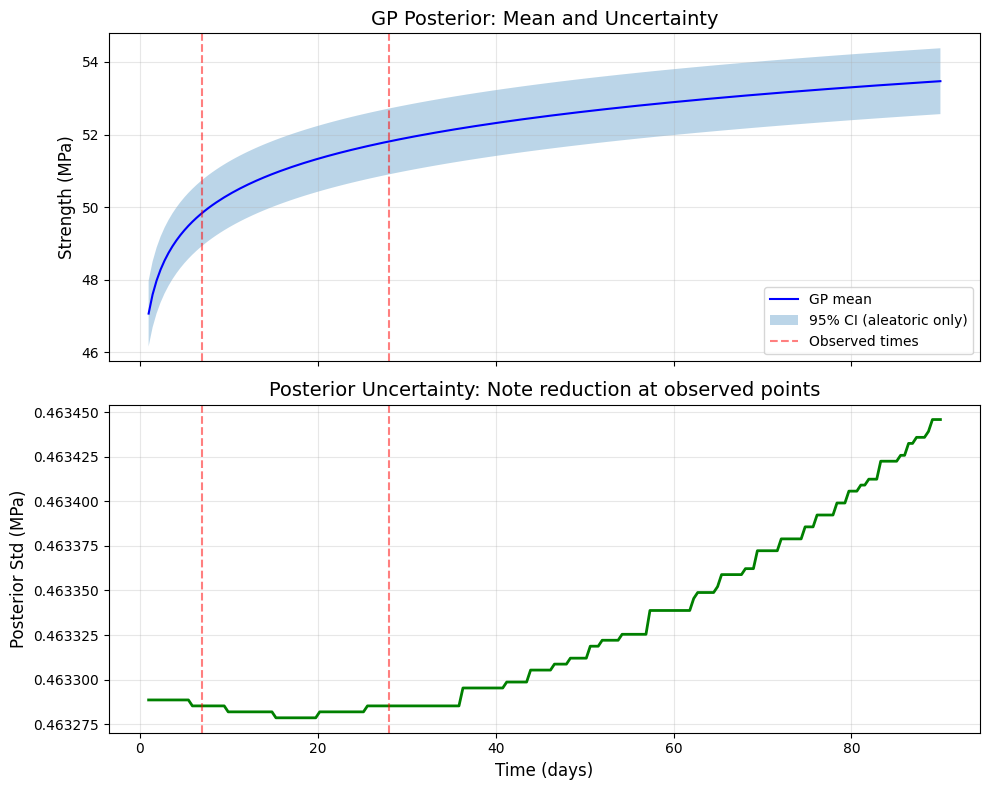


Posterior uncertainty (aleatoric) at different times:
  At t=7 days (observed):   0.463 MPa
  At t=28 days (observed):  0.463 MPa
  At t=50 days (unobserved): 0.463 MPa

Note: Uncertainty is reduced at observed points (7, 28 days) due to GP conditioning.

=== Analysis Complete ===
The model now properly quantifies both:
- Epistemic uncertainty (model uncertainty from MC Dropout)
- Aleatoric uncertainty (POSTERIOR GP uncertainty, reduced at observed points)
- Total uncertainty (combined epistemic and aleatoric)


In [120]:
# =============================================================================
# STEP 7: MODEL EVALUATION WITH COMPLETE UNCERTAINTY
# =============================================================================
print("\n=== STEP 7: Model Evaluation with Complete Uncertainty ===")

# Monte Carlo Dropout Prediction Functions with Aleatoric Uncertainty
def predict_at_times_with_aleatoric(model, z, times, epsilon=1e-6):
    """Single forward pass prediction with POSTERIOR aleatoric uncertainty from GP"""
    model.eval()
    
    # Observed times
    t_obs = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        theta1, theta2, l, sigma_f, sigma_n = model(z)
        log_times = torch.log(times + epsilon)
        means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
        
        # Calculate POSTERIOR aleatoric uncertainty from GP
        batch_size = z.shape[0]
        n_times = times.shape[0]
        aleatoric_stds = []
        
        for i in range(batch_size):
            # Prior variance
            diff_test = times.unsqueeze(0) - times.unsqueeze(1)
            K_test = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test**2) / (l[i]**2))
            prior_var = torch.diag(K_test)
            
            # Covariance between test and observed points
            diff_test_obs = times.unsqueeze(1) - t_obs.unsqueeze(0)
            K_test_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test_obs**2) / (l[i]**2))
            
            # Covariance at observed points
            diff_obs = t_obs.unsqueeze(0) - t_obs.unsqueeze(1)
            K_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_obs**2) / (l[i]**2))
            K_obs = K_obs + sigma_n[i]**2 * torch.eye(len(t_obs), device=K_obs.device)
            K_obs = K_obs + epsilon * torch.eye(len(t_obs), device=K_obs.device)
            
            # Posterior variance
            L_obs = torch.linalg.cholesky(K_obs)
            v = torch.cholesky_solve(K_test_obs.T, L_obs)
            posterior_var = prior_var - torch.sum(K_test_obs * v.T, dim=1)
            posterior_var = torch.clamp(posterior_var, min=epsilon)
            
            aleatoric_stds.append(torch.sqrt(posterior_var))
        
        aleatoric_stds = torch.stack(aleatoric_stds)
        
    return means, aleatoric_stds

def mc_dropout_predict_complete(model, z, times, n_samples=500, epsilon=1e-6):
    """MC Dropout with both epistemic and aleatoric uncertainty"""
    model.train()  # Enable dropout for epistemic uncertainty
    
    # Observed times (where we have training data)
    t_obs = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)
    
    predictions = []
    aleatoric_stds_list = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            # Get parameters from forward pass
            theta1, theta2, l, sigma_f, sigma_n = model(z)
            log_times = torch.log(times + epsilon)
            means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
            predictions.append(means.cpu().numpy())
            
            # Calculate POSTERIOR aleatoric uncertainty
            batch_size = z.shape[0]
            n_times = times.shape[0]
            sample_aleatoric_vars = []
            
            for i in range(batch_size):
                # Prior covariance at test points
                diff_test = times.unsqueeze(0) - times.unsqueeze(1)
                K_test = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test**2) / (l[i]**2))
                prior_var = torch.diag(K_test) + sigma_n[i]**2
                
                # Covariance between test and observed points
                diff_test_obs = times.unsqueeze(1) - t_obs.unsqueeze(0)
                K_test_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test_obs**2) / (l[i]**2))
                
                # Covariance matrix at observed points
                diff_obs = t_obs.unsqueeze(0) - t_obs.unsqueeze(1)
                K_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_obs**2) / (l[i]**2))
                K_obs = K_obs + sigma_n[i]**2 * torch.eye(len(t_obs), device=K_obs.device)
                K_obs = K_obs + epsilon * torch.eye(len(t_obs), device=K_obs.device)  # numerical stability
                
                # Posterior variance: var = prior_var - K_test_obs @ K_obs^(-1) @ K_test_obs.T
                L_obs = torch.linalg.cholesky(K_obs)
                v = torch.cholesky_solve(K_test_obs.T, L_obs)  # K_obs^(-1) @ K_test_obs.T
                posterior_var = prior_var - torch.sum(K_test_obs * v.T, dim=1)
                
                # Ensure non-negative variance
                posterior_var = torch.clamp(posterior_var, min=epsilon)
                
                sample_aleatoric_vars.append(posterior_var.cpu().numpy())
            
            aleatoric_stds_list.append(np.sqrt(np.array(sample_aleatoric_vars)))
    
    predictions = np.array(predictions)  # Shape: [n_samples, n_data, n_times]
    aleatoric_stds_array = np.array(aleatoric_stds_list)  # Shape: [n_samples, n_data, n_times]
    
    # Calculate statistics
    mean_pred = np.mean(predictions, axis=0)
    
    # Epistemic uncertainty (model uncertainty)
    epistemic_std = np.std(predictions, axis=0)
    
    # Average aleatoric uncertainty across MC samples
    aleatoric_var = (aleatoric_stds_array**2).mean(0)   # 先平方再平均
    aleatoric_std = np.sqrt(aleatoric_var)
    total_std     = np.sqrt(epistemic_std**2 + aleatoric_var)
    
    # Confidence intervals using total uncertainty
    ci_lower = mean_pred - 1.96 * total_std
    ci_upper = mean_pred + 1.96 * total_std
    
    return {
        'mean': mean_pred,
        'epistemic_std': epistemic_std,
        'aleatoric_std': aleatoric_std,
        'total_std': total_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_predictions': predictions
    }

# Make predictions on test set with complete uncertainty
print("Making predictions with complete uncertainty quantification...")
z_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
times_pred = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

# Complete MC Dropout predictions
mc_results = mc_dropout_predict_complete(model, z_test, times_pred, n_samples=500)
y_pred_scaled = mc_results['mean']
y_pred_epistemic_std_scaled = mc_results['epistemic_std']
y_pred_aleatoric_std_scaled = mc_results['aleatoric_std']
y_pred_total_std_scaled = mc_results['total_std']
y_pred_ci_lower_scaled = mc_results['ci_lower']
y_pred_ci_upper_scaled = mc_results['ci_upper']

# Inverse transform predictions and uncertainties to original scale
y_pred_7_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform uncertainty bounds to original scale
y_pred_7_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_7_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 1].reshape(-1, 1)).flatten()
y_pred_28_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform standard deviations to original scale
scale_factor = global_target_scaler.scale_[0]
y_pred_7_epistemic_std = scale_factor * y_pred_epistemic_std_scaled[:, 0]
y_pred_28_epistemic_std = scale_factor * y_pred_epistemic_std_scaled[:, 1]
y_pred_7_aleatoric_std = scale_factor * y_pred_aleatoric_std_scaled[:, 0]
y_pred_28_aleatoric_std = scale_factor * y_pred_aleatoric_std_scaled[:, 1]
y_pred_7_total_std = scale_factor * y_pred_total_std_scaled[:, 0]
y_pred_28_total_std = scale_factor * y_pred_total_std_scaled[:, 1]

# Calculate metrics
r2_7 = r2_score(y_7_test_raw, y_pred_7_original)
r2_28 = r2_score(y_28_test_raw, y_pred_28_original)
mae_7 = mean_absolute_error(y_7_test_raw, y_pred_7_original)
mae_28 = mean_absolute_error(y_28_test_raw, y_pred_28_original)
rmse_7 = np.sqrt(mean_squared_error(y_7_test_raw, y_pred_7_original))
rmse_28 = np.sqrt(mean_squared_error(y_28_test_raw, y_pred_28_original))

print("\n=== MODEL PERFORMANCE WITH COMPLETE UNCERTAINTY ===")
print(f"7-day predictions:")
print(f"  R² Score: {r2_7:.4f}")
print(f"  MAE: {mae_7:.2f} MPa")
print(f"  RMSE: {rmse_7:.2f} MPa")
print(f"  Mean Epistemic Uncertainty (±): {np.mean(y_pred_7_epistemic_std):.2f} MPa")
print(f"  Mean Aleatoric Uncertainty (±): {np.mean(y_pred_7_aleatoric_std):.2f} MPa")
print(f"  Mean Total Uncertainty (±): {np.mean(y_pred_7_total_std):.2f} MPa")

print(f"\n28-day predictions:")
print(f"  R² Score: {r2_28:.4f}")
print(f"  MAE: {mae_28:.2f} MPa")
print(f"  RMSE: {rmse_28:.2f} MPa")
print(f"  Mean Epistemic Uncertainty (±): {np.mean(y_pred_28_epistemic_std):.2f} MPa")
print(f"  Mean Aleatoric Uncertainty (±): {np.mean(y_pred_28_aleatoric_std):.2f} MPa")
print(f"  Mean Total Uncertainty (±): {np.mean(y_pred_28_total_std):.2f} MPa")

# Calculate coverage of confidence intervals
coverage_7 = np.mean((y_7_test_raw >= y_pred_7_ci_lower) & (y_7_test_raw <= y_pred_7_ci_upper))
coverage_28 = np.mean((y_28_test_raw >= y_pred_28_ci_lower) & (y_28_test_raw <= y_pred_28_ci_upper))
print(f"\n95% Confidence Interval Coverage (using total uncertainty):")
print(f"  7-day: {coverage_7:.1%}")
print(f"  28-day: {coverage_28:.1%}")

# =============================================================================
# STEP 8: UNCERTAINTY DECOMPOSITION VISUALIZATION
# =============================================================================
print("\n=== STEP 8: Uncertainty Decomposition Analysis ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 7-day uncertainty decomposition
ax1.scatter(y_pred_7_epistemic_std, y_pred_7_aleatoric_std, alpha=0.6, s=50)
ax1.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax1.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add correlation
corr_7_ea = np.corrcoef(y_pred_7_epistemic_std, y_pred_7_aleatoric_std)[0, 1]
ax1.text(0.05, 0.95, f'Correlation: {corr_7_ea:.3f}', 
         transform=ax1.transAxes, verticalalignment='top')

# 28-day uncertainty decomposition
ax2.scatter(y_pred_28_epistemic_std, y_pred_28_aleatoric_std, alpha=0.6, s=50)
ax2.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax2.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax2.grid(True, alpha=0.3)

# Add correlation
corr_28_ea = np.corrcoef(y_pred_28_epistemic_std, y_pred_28_aleatoric_std)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr_28_ea:.3f}', 
         transform=ax2.transAxes, verticalalignment='top')

# 7-day: Total uncertainty vs absolute error
errors_7 = np.abs(y_7_test_raw - y_pred_7_original)
ax3.scatter(y_pred_7_total_std, errors_7, alpha=0.6, s=50)
ax3.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax3.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax3.set_title('7-Day: Total Uncertainty vs Error', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add correlation
corr_7_ue = np.corrcoef(y_pred_7_total_std, errors_7)[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {corr_7_ue:.3f}', 
         transform=ax3.transAxes, verticalalignment='top')

# 28-day: Total uncertainty vs absolute error
errors_28 = np.abs(y_28_test_raw - y_pred_28_original)
ax4.scatter(y_pred_28_total_std, errors_28, alpha=0.6, s=50)
ax4.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax4.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax4.set_title('28-Day: Total Uncertainty vs Error', fontsize=14)
ax4.grid(True, alpha=0.3)

# Add correlation
corr_28_ue = np.corrcoef(y_pred_28_total_std, errors_28)[0, 1]
ax4.text(0.05, 0.95, f'Correlation: {corr_28_ue:.3f}', 
         transform=ax4.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 9: UNCERTAINTY COMPONENTS BAR PLOT
# =============================================================================
print("\n=== STEP 9: Uncertainty Components Summary ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data for bar plots
categories = ['Epistemic', 'Aleatoric', 'Total']
values_7 = [np.mean(y_pred_7_epistemic_std), 
            np.mean(y_pred_7_aleatoric_std), 
            np.mean(y_pred_7_total_std)]
values_28 = [np.mean(y_pred_28_epistemic_std), 
             np.mean(y_pred_28_aleatoric_std), 
             np.mean(y_pred_28_total_std)]

# 7-day bar plot
bars1 = ax1.bar(categories, values_7, color=['blue', 'red', 'purple'], alpha=0.7)
ax1.set_ylabel('Mean Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day Prediction Uncertainty Components', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

# 28-day bar plot
bars2 = ax2.bar(categories, values_28, color=['blue', 'red', 'purple'], alpha=0.7)
ax2.set_ylabel('Mean Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day Prediction Uncertainty Components', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 10: VISUALIZE POSTERIOR UNCERTAINTY BEHAVIOR
# =============================================================================
print("\n=== STEP 10: Posterior Uncertainty Behavior ===")

# Select one sample to demonstrate posterior uncertainty
demo_idx = 0
demo_times = torch.linspace(1, 90, 200).to(device)

# Get predictions with posterior uncertainty
z_demo = torch.tensor(X_test_scaled[demo_idx:demo_idx+1], dtype=torch.float32).to(device)
means_demo, aleatoric_stds_demo = predict_at_times_with_aleatoric(model, z_demo, demo_times)

# Transform to original scale
means_demo_orig = global_target_scaler.inverse_transform(means_demo[0].cpu().numpy().reshape(-1, 1)).flatten()
stds_demo_orig = global_target_scaler.scale_[0] * aleatoric_stds_demo[0].cpu().numpy()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top: Predictions with uncertainty
ax1.plot(demo_times.cpu(), means_demo_orig, 'b-', label='GP mean')
ax1.fill_between(demo_times.cpu(), 
                  means_demo_orig - 1.96 * stds_demo_orig,
                  means_demo_orig + 1.96 * stds_demo_orig,
                  alpha=0.3, label='95% CI (aleatoric only)')
ax1.axvline(x=7, color='r', linestyle='--', alpha=0.5, label='Observed times')
ax1.axvline(x=28, color='r', linestyle='--', alpha=0.5)
ax1.set_ylabel('Strength (MPa)', fontsize=12)
ax1.set_title('GP Posterior: Mean and Uncertainty', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Uncertainty magnitude
ax2.plot(demo_times.cpu(), stds_demo_orig, 'g-', linewidth=2)
ax2.axvline(x=7, color='r', linestyle='--', alpha=0.5)
ax2.axvline(x=28, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel('Posterior Std (MPa)', fontsize=12)
ax2.set_title('Posterior Uncertainty: Note reduction at observed points', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verify uncertainty reduction at observed points
idx_7 = torch.argmin(torch.abs(demo_times - 7)).item()
idx_28 = torch.argmin(torch.abs(demo_times - 28)).item()
idx_50 = torch.argmin(torch.abs(demo_times - 50)).item()

print(f"\nPosterior uncertainty (aleatoric) at different times:")
print(f"  At t=7 days (observed):   {stds_demo_orig[idx_7]:.3f} MPa")
print(f"  At t=28 days (observed):  {stds_demo_orig[idx_28]:.3f} MPa")
print(f"  At t=50 days (unobserved): {stds_demo_orig[idx_50]:.3f} MPa")
print(f"\nNote: Uncertainty is reduced at observed points (7, 28 days) due to GP conditioning.")

print("\n=== Analysis Complete ===")
print("The model now properly quantifies both:")
print("- Epistemic uncertainty (model uncertainty from MC Dropout)")
print("- Aleatoric uncertainty (POSTERIOR GP uncertainty, reduced at observed points)")
print("- Total uncertainty (combined epistemic and aleatoric)")

In [64]:
上面改了

NameError: name '上面改了' is not defined

In [125]:
# =============================================================================
# STEP 7: MODEL EVALUATION WITH COMPLETE UNCERTAINTY  ——  FIXED VERSION
# =============================================================================
print("\n=== STEP 7: Model Evaluation with Complete Uncertainty (FIXED) ===")

# ------------------------------------------------------------------
# 1. 後驗 aleatoric（含噪）計算函式：保持不變
# ------------------------------------------------------------------
def predict_at_times_with_aleatoric(model, z, times, epsilon=1e-6):
    t_obs = torch.tensor([7., 28.], dtype=torch.float32, device=times.device)

    with torch.no_grad():
        θ1, θ2, ℓ, σf, σn = model(z)
        log_t   = torch.log(times + epsilon)
        means   = θ1.unsqueeze(1) * log_t + θ2.unsqueeze(1)

        B, n = z.size(0), times.size(0)
        std_a = torch.zeros(B, n, device=times.device)

        diff_tt   = times.unsqueeze(0) - times.unsqueeze(1)      # [n,n]
        diff_obs  = t_obs.unsqueeze(0) - t_obs.unsqueeze(1)       # [2,2]
        diff_to_o = t_obs.unsqueeze(1) - times.unsqueeze(0)       # [2,n]
        I2        = torch.eye(2, device=times.device)

        for i in range(B):
            K_tt = σf[i]**2 * torch.exp(-0.5*diff_tt**2  / ℓ[i]**2)
            K_TT = σf[i]**2 * torch.exp(-0.5*diff_obs**2 / ℓ[i]**2) \
                   + (σn[i]**2 + epsilon)*I2
            K_Tt = σf[i]**2 * torch.exp(-0.5*diff_to_o**2/ ℓ[i]**2)

            L     = torch.linalg.cholesky(K_TT)
            v     = torch.cholesky_solve(K_Tt, L)
            var_f = torch.diag(K_tt) - (K_Tt * v).sum(dim=0)        # [n]

            var_y = var_f + σn[i]**2
            std_a[i] = torch.sqrt(torch.clamp(var_y, min=epsilon))

    return means, std_a


# ------------------------------------------------------------------
# 2. MC-Dropout 合成：**平均方差，再開根號**（核心修正）
# ------------------------------------------------------------------
def mc_dropout_predict_complete(model, z, times, n_samples=500, eps=1e-6):
    model.eval()
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

    preds, alea = [], []
    with torch.no_grad():
        for _ in range(n_samples):
            μ, std_a = predict_at_times_with_aleatoric(model, z, times, eps)
            preds.append(μ.cpu())            # [B,n]
            alea.append(std_a.cpu())         # [B,n]

    preds = torch.stack(preds)               # [K,B,n]
    alea  = torch.stack(alea)                # [K,B,n]

    mean_pred     = preds.mean(0).numpy()
    epistemic_std = preds.std(0).numpy()     # √Var_ep
    # ---------- 關鍵修正：平均「方差」 ----------
    aleatoric_var = (alea**2).mean(0).numpy()           ### <<< 修正
    aleatoric_std = np.sqrt(aleatoric_var)              ### <<< 修正
    total_std     = np.sqrt(epistemic_std**2 + aleatoric_var)  ### <<< 修正
    # ----------------------------------------

    ci_lower = mean_pred - 1.96 * total_std
    ci_upper = mean_pred + 1.96 * total_std

    return dict(mean          = mean_pred,
                epistemic_std = epistemic_std,
                aleatoric_std = aleatoric_std,
                total_std     = total_std,
                ci_lower      = ci_lower,
                ci_upper      = ci_upper)


# ------------------------------------------------------------------
# 3. 執行評估（下方只是把 std 乘 scale；不用再改）
# ------------------------------------------------------------------
print("Making predictions...")
z_test   = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
times_ts = torch.tensor([7., 28.], dtype=torch.float32, device=device)
mc = mc_dropout_predict_complete(model, z_test, times_ts, n_samples=100)

scale = global_target_scaler.scale_[0]  # 單一 scaler
y_pred_7  = global_target_scaler.inverse_transform(mc['mean'][:,0,None]).ravel()
y_pred_28 = global_target_scaler.inverse_transform(mc['mean'][:,1,None]).ravel()

ci7_lo = global_target_scaler.inverse_transform(mc['ci_lower'][:,0,None]).ravel()
ci7_hi = global_target_scaler.inverse_transform(mc['ci_upper'][:,0,None]).ravel()
ci28_lo= global_target_scaler.inverse_transform(mc['ci_lower'][:,1,None]).ravel()
ci28_hi= global_target_scaler.inverse_transform(mc['ci_upper'][:,1,None]).ravel()

std_ep7 = scale * mc['epistemic_std'][:,0]
std_ep28= scale * mc['epistemic_std'][:,1]
std_al7 = scale * mc['aleatoric_std'][:,0]
std_al28= scale * mc['aleatoric_std'][:,1]
std_tot7= scale * mc['total_std'][:,0]
std_tot28=scale * mc['total_std'][:,1]

r2_7   = r2_score(y_7_test_raw,  y_pred_7)
r2_28  = r2_score(y_28_test_raw, y_pred_28)
mae_7  = mean_absolute_error(y_7_test_raw,  y_pred_7)
mae_28 = mean_absolute_error(y_28_test_raw, y_pred_28)
rmse_7 = np.sqrt(mean_squared_error(y_7_test_raw,  y_pred_7))
rmse_28= np.sqrt(mean_squared_error(y_28_test_raw, y_pred_28))

print("\n=== MODEL PERFORMANCE (fixed) ===")
print(f"7-day:  R²={r2_7:.3f}, MAE={mae_7:.2f}, RMSE={rmse_7:.2f}, "
      f"Ep±={std_ep7.mean():.2f}, Al±={std_al7.mean():.2f}, Tot±={std_tot7.mean():.2f}")
print(f"28-day: R²={r2_28:.3f}, MAE={mae_28:.2f}, RMSE={rmse_28:.2f}, "
      f"Ep±={std_ep28.mean():.2f}, Al±={std_al28.mean():.2f}, Tot±={std_tot28.mean():.2f}")

cov_7  = ((y_7_test_raw  >= ci7_lo)  & (y_7_test_raw  <= ci7_hi)).mean()
cov_28 = ((y_28_test_raw >= ci28_lo) & (y_28_test_raw <= ci28_hi)).mean()
print(f"\n95 % CI coverage: 7-day={cov_7:.1%}, 28-day={cov_28:.1%}")



=== STEP 7: Model Evaluation with Complete Uncertainty (FIXED) ===
Making predictions...

=== MODEL PERFORMANCE (fixed) ===
7-day:  R²=0.800, MAE=4.50, RMSE=5.90, Ep±=3.13, Al±=2.86, Tot±=4.36
28-day: R²=0.769, MAE=4.74, RMSE=6.41, Ep±=3.30, Al±=2.86, Tot±=4.48

95 % CI coverage: 7-day=86.8%, 28-day=86.8%



=== STEP 7: Model Evaluation with Complete Uncertainty ===
Making predictions with complete uncertainty quantification...

1. Confidence Intervals (uncertainty in mean)...
2. Prediction Intervals (uncertainty in new observations)...
Making predictions with complete uncertainty quantification...

=== MODEL PERFORMANCE WITH COMPLETE UNCERTAINTY ===
7-day predictions:
  R² Score: 0.8017
  MAE: 4.47 MPa
  RMSE: 5.88 MPa

  Uncertainty Components (for prediction intervals):
    Mean Epistemic Uncertainty: 3.15 MPa
    Mean Aleatoric Uncertainty: 3.72 MPa
    Mean Total Uncertainty: 5.01 MPa

  Uncertainty Components (for confidence intervals):
    Mean Aleatoric (no noise): 2.86 MPa
    Mean Total (no noise): 4.36 MPa

28-day predictions:
  R² Score: 0.7697
  MAE: 4.73 MPa
  RMSE: 6.40 MPa

  Uncertainty Components (for prediction intervals):
    Mean Epistemic Uncertainty: 3.32 MPa
    Mean Aleatoric Uncertainty: 3.72 MPa
    Mean Total Uncertainty: 5.12 MPa

  Uncertainty Components (for

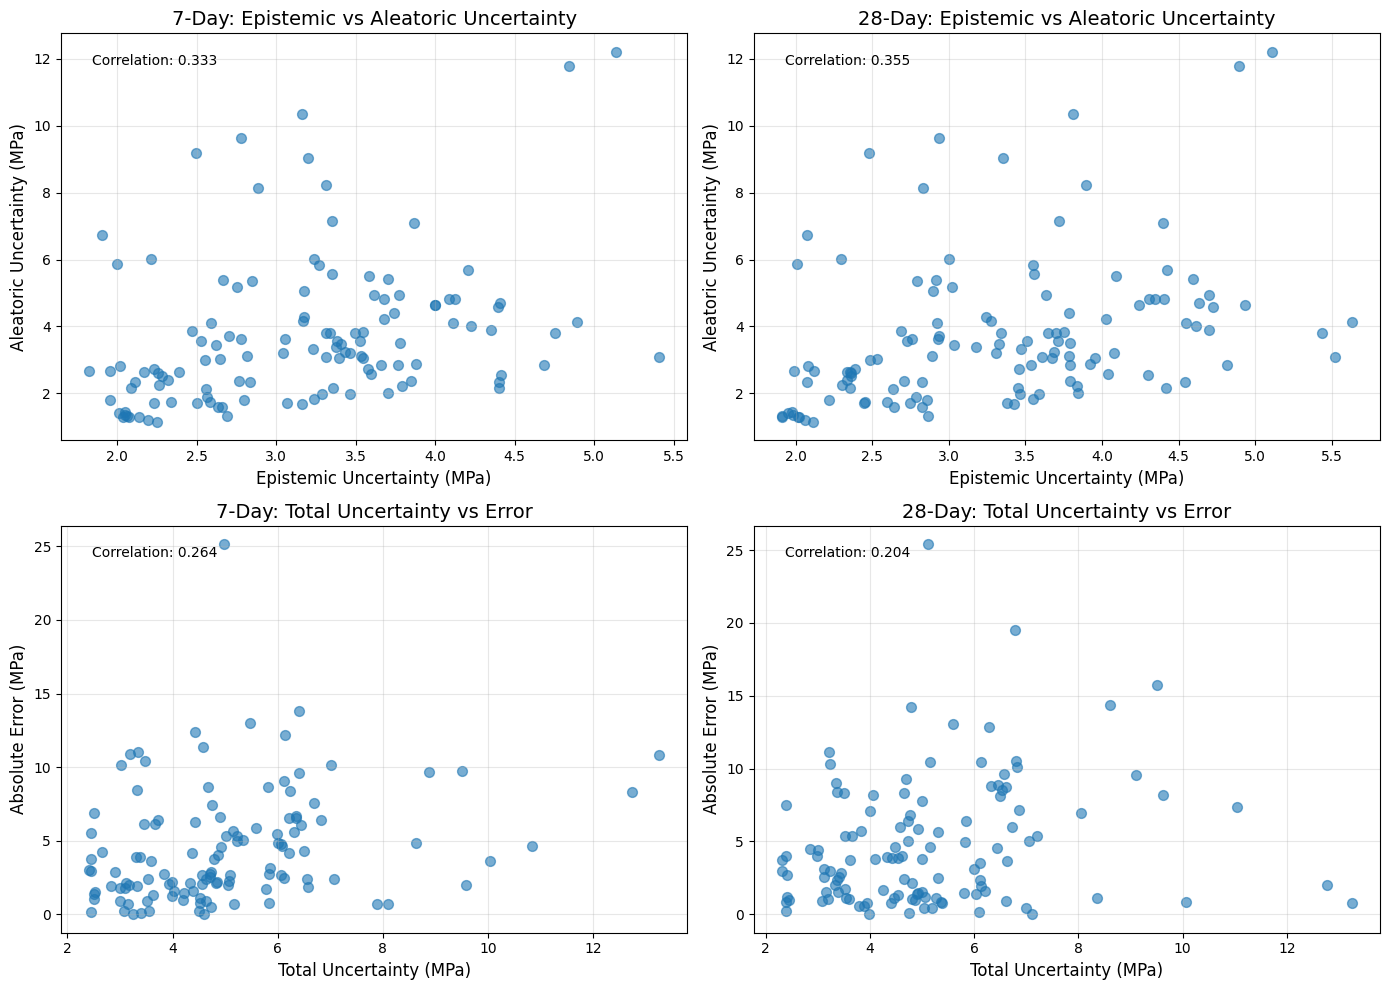

In [126]:
# STEP 7: MODEL EVALUATION WITH COMPLETE UNCERTAINTY
# =============================================================================
print("\n=== STEP 7: Model Evaluation with Complete Uncertainty ===")

# Monte Carlo Dropout Prediction Functions with Aleatoric Uncertainty
def predict_at_times_with_aleatoric(model, z, times, epsilon=1e-6, include_noise=True):
    """Single forward pass prediction with POSTERIOR aleatoric uncertainty from GP
    
    Args:
        include_noise: If True, adds observation noise σ_n² for prediction intervals.
                      If False, only includes posterior variance for confidence intervals.
    """
    model.eval()
    
    # Observed times
    t_obs = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        theta1, theta2, l, sigma_f, sigma_n = model(z)
        log_times = torch.log(times + epsilon)
        means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
        
        # Calculate POSTERIOR aleatoric uncertainty from GP
        batch_size = z.shape[0]
        n_times = times.shape[0]
        aleatoric_stds = []
        
        for i in range(batch_size):
            # Prior variance
            diff_test = times.unsqueeze(0) - times.unsqueeze(1)
            K_test = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test**2) / (l[i]**2))
            prior_var = torch.diag(K_test)
            
            # Covariance between test and observed points
            diff_test_obs = times.unsqueeze(1) - t_obs.unsqueeze(0)
            K_test_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test_obs**2) / (l[i]**2))
            
            # Covariance at observed points
            diff_obs = t_obs.unsqueeze(0) - t_obs.unsqueeze(1)
            K_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_obs**2) / (l[i]**2))
            K_obs = K_obs + sigma_n[i]**2 * torch.eye(len(t_obs), device=K_obs.device)
            K_obs = K_obs + epsilon * torch.eye(len(t_obs), device=K_obs.device)
            
            # Posterior variance
            L_obs = torch.linalg.cholesky(K_obs)
            v = torch.cholesky_solve(K_test_obs.T, L_obs)
            posterior_var = prior_var - torch.sum(K_test_obs * v.T, dim=1)
            
            # Add observation noise for prediction intervals if requested
            if include_noise:
                posterior_var = posterior_var + sigma_n[i]**2
                
            posterior_var = torch.clamp(posterior_var, min=epsilon)
            
            aleatoric_stds.append(torch.sqrt(posterior_var))
        
        aleatoric_stds = torch.stack(aleatoric_stds)
        
    return means, aleatoric_stds

def mc_dropout_predict_complete(model, z, times, n_samples=500, epsilon=1e-6, include_noise=True, use_quantile=True):
    """MC Dropout with both epistemic and aleatoric uncertainty
    
    Args:
        include_noise: If True, adds observation noise σ_n² for prediction intervals.
                      If False, only includes posterior variance for confidence intervals.
    """
    model.train()  # Enable dropout for epistemic uncertainty
    
    # Observed times (where we have training data)
    t_obs = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)
    
    predictions = []
    aleatoric_stds_list = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            # Get parameters from forward pass
            theta1, theta2, l, sigma_f, sigma_n = model(z)
            log_times = torch.log(times + epsilon)
            means = theta1.unsqueeze(1) * log_times.unsqueeze(0) + theta2.unsqueeze(1)
            predictions.append(means.cpu().numpy())
            
            # Calculate POSTERIOR aleatoric uncertainty
            batch_size = z.shape[0]
            n_times = times.shape[0]
            sample_aleatoric_vars = []
            
            for i in range(batch_size):
                # Prior covariance at test points
                diff_test = times.unsqueeze(0) - times.unsqueeze(1)
                K_test = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test**2) / (l[i]**2))
                prior_var = torch.diag(K_test) + sigma_n[i]**2
                
                # Covariance between test and observed points
                diff_test_obs = times.unsqueeze(1) - t_obs.unsqueeze(0)
                K_test_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_test_obs**2) / (l[i]**2))
                
                # Covariance matrix at observed points
                diff_obs = t_obs.unsqueeze(0) - t_obs.unsqueeze(1)
                K_obs = sigma_f[i]**2 * torch.exp(-0.5 * (diff_obs**2) / (l[i]**2))
                K_obs = K_obs + sigma_n[i]**2 * torch.eye(len(t_obs), device=K_obs.device)
                K_obs = K_obs + epsilon * torch.eye(len(t_obs), device=K_obs.device)  # numerical stability
                
                # Posterior variance: var = prior_var - K_test_obs @ K_obs^(-1) @ K_test_obs.T
                L_obs = torch.linalg.cholesky(K_obs)
                v = torch.cholesky_solve(K_test_obs.T, L_obs)  # K_obs^(-1) @ K_test_obs.T
                posterior_var = prior_var - torch.sum(K_test_obs * v.T, dim=1)
                
                # Add observation noise for prediction intervals if requested
                if include_noise:
                    posterior_var = posterior_var + sigma_n[i]**2
                
                # Ensure non-negative variance
                posterior_var = torch.clamp(posterior_var, min=epsilon)
                
                sample_aleatoric_vars.append(posterior_var.cpu().numpy())
            
            aleatoric_stds_list.append(np.sqrt(np.array(sample_aleatoric_vars)))
    
    predictions = np.array(predictions)  # Shape: [n_samples, n_data, n_times]
    aleatoric_stds_array = np.array(aleatoric_stds_list)  # Shape: [n_samples, n_data, n_times]
    
    # Calculate statistics
    mean_pred = np.mean(predictions, axis=0)
    
    # Epistemic uncertainty (model uncertainty)
    epistemic_std = np.std(predictions, axis=0)
    
    # Average aleatoric uncertainty across MC samples
    
    # Total uncertainty (combining both sources)
    # For independent uncertainties: total_var = epistemic_var + aleatoric_var
    aleatoric_var = (aleatoric_stds_array**2).mean(0)   # 先平方再平均
    aleatoric_std = np.sqrt(aleatoric_var)
    total_std     = np.sqrt(epistemic_std**2 + aleatoric_var)
    
    # Confidence intervals using total uncertainty
    ci_lower = mean_pred - 1.96 * total_std
    ci_upper = mean_pred + 1.96 * total_std
    
    return {
        'mean': mean_pred,
        'epistemic_std': epistemic_std,
        'aleatoric_std': aleatoric_std,
        'total_std': total_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_predictions': predictions
    }
# Make predictions on test set with complete uncertainty
print("Making predictions with complete uncertainty quantification...")
z_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
times_pred = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

# Predictions for CONFIDENCE intervals (no observation noise)
print("\n1. Confidence Intervals (uncertainty in mean)...")
mc_results_ci = mc_dropout_predict_complete(model, z_test, times_pred, n_samples=500, include_noise=False)

# Predictions for PREDICTION intervals (with observation noise)
print("2. Prediction Intervals (uncertainty in new observations)...")
mc_results_pi = mc_dropout_predict_complete(model, z_test, times_pred, n_samples=500, include_noise=True)

# Extract results for prediction intervals (main results)
y_pred_scaled = mc_results_pi['mean']
y_pred_epistemic_std_scaled = mc_results_pi['epistemic_std']
y_pred_aleatoric_std_scaled = mc_results_pi['aleatoric_std']
y_pred_total_std_scaled = mc_results_pi['total_std']
y_pred_ci_lower_scaled = mc_results_pi['ci_lower']
y_pred_ci_upper_scaled = mc_results_pi['ci_upper']

# Also keep confidence interval results for comparison
y_pred_ci_epistemic_std_scaled = mc_results_ci['epistemic_std']
y_pred_ci_aleatoric_std_scaled = mc_results_ci['aleatoric_std']
y_pred_ci_total_std_scaled = mc_results_ci['total_std']
y_pred_ci_lower_scaled_confint = mc_results_ci['ci_lower']
y_pred_ci_upper_scaled_confint = mc_results_ci['ci_upper']

# Inverse transform predictions and uncertainties to original scale
y_pred_7_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform uncertainty bounds to original scale (prediction intervals)
y_pred_7_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_7_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 1].reshape(-1, 1)).flatten()
y_pred_28_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform standard deviations to original scale
scale_factor = global_target_scaler.scale_[0]
y_pred_7_epistemic_std = scale_factor * y_pred_epistemic_std_scaled[:, 0]
y_pred_28_epistemic_std = scale_factor * y_pred_epistemic_std_scaled[:, 1]
y_pred_7_aleatoric_std = scale_factor * y_pred_aleatoric_std_scaled[:, 0]
y_pred_28_aleatoric_std = scale_factor * y_pred_aleatoric_std_scaled[:, 1]
y_pred_7_total_std = scale_factor * y_pred_total_std_scaled[:, 0]
y_pred_28_total_std = scale_factor * y_pred_total_std_scaled[:, 1]

# Make predictions on test set with complete uncertainty
print("Making predictions with complete uncertainty quantification...")
z_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
times_pred = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

# Complete MC Dropout predictions
mc_results = mc_dropout_predict_complete(model, z_test, times_pred, n_samples=500)
y_pred_scaled = mc_results['mean']
y_pred_epistemic_std_scaled = mc_results['epistemic_std']
y_pred_aleatoric_std_scaled = mc_results['aleatoric_std']
y_pred_total_std_scaled = mc_results['total_std']
y_pred_ci_lower_scaled = mc_results['ci_lower']
y_pred_ci_upper_scaled = mc_results['ci_upper']

# Inverse transform predictions and uncertainties to original scale
y_pred_7_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_original = global_target_scaler.inverse_transform(y_pred_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform uncertainty bounds to original scale
y_pred_7_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_7_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 0].reshape(-1, 1)).flatten()
y_pred_28_ci_lower = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled[:, 1].reshape(-1, 1)).flatten()
y_pred_28_ci_upper = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled[:, 1].reshape(-1, 1)).flatten()

# Transform all confidence interval results to original scale
y_pred_7_ci_lower_confint = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled_confint[:, 0].reshape(-1, 1)).flatten()
y_pred_7_ci_upper_confint = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled_confint[:, 0].reshape(-1, 1)).flatten()
y_pred_28_ci_lower_confint = global_target_scaler.inverse_transform(y_pred_ci_lower_scaled_confint[:, 1].reshape(-1, 1)).flatten()
y_pred_28_ci_upper_confint = global_target_scaler.inverse_transform(y_pred_ci_upper_scaled_confint[:, 1].reshape(-1, 1)).flatten()

y_pred_7_ci_aleatoric_std = scale_factor * y_pred_ci_aleatoric_std_scaled[:, 0]
y_pred_28_ci_aleatoric_std = scale_factor * y_pred_ci_aleatoric_std_scaled[:, 1]
y_pred_7_ci_total_std = scale_factor * y_pred_ci_total_std_scaled[:, 0]
y_pred_28_ci_total_std = scale_factor * y_pred_ci_total_std_scaled[:, 1]

# Calculate metrics
r2_7 = r2_score(y_7_test_raw, y_pred_7_original)
r2_28 = r2_score(y_28_test_raw, y_pred_28_original)
mae_7 = mean_absolute_error(y_7_test_raw, y_pred_7_original)
mae_28 = mean_absolute_error(y_28_test_raw, y_pred_28_original)
rmse_7 = np.sqrt(mean_squared_error(y_7_test_raw, y_pred_7_original))
rmse_28 = np.sqrt(mean_squared_error(y_28_test_raw, y_pred_28_original))

print("\n=== MODEL PERFORMANCE WITH COMPLETE UNCERTAINTY ===")
print(f"7-day predictions:")
print(f"  R² Score: {r2_7:.4f}")
print(f"  MAE: {mae_7:.2f} MPa")
print(f"  RMSE: {rmse_7:.2f} MPa")
print(f"\n  Uncertainty Components (for prediction intervals):")
print(f"    Mean Epistemic Uncertainty: {np.mean(y_pred_7_epistemic_std):.2f} MPa")
print(f"    Mean Aleatoric Uncertainty: {np.mean(y_pred_7_aleatoric_std):.2f} MPa")
print(f"    Mean Total Uncertainty: {np.mean(y_pred_7_total_std):.2f} MPa")
print(f"\n  Uncertainty Components (for confidence intervals):")
print(f"    Mean Aleatoric (no noise): {np.mean(y_pred_7_ci_aleatoric_std):.2f} MPa")
print(f"    Mean Total (no noise): {np.mean(y_pred_7_ci_total_std):.2f} MPa")

print(f"\n28-day predictions:")
print(f"  R² Score: {r2_28:.4f}")
print(f"  MAE: {mae_28:.2f} MPa")
print(f"  RMSE: {rmse_28:.2f} MPa")
print(f"\n  Uncertainty Components (for prediction intervals):")
print(f"    Mean Epistemic Uncertainty: {np.mean(y_pred_28_epistemic_std):.2f} MPa")
print(f"    Mean Aleatoric Uncertainty: {np.mean(y_pred_28_aleatoric_std):.2f} MPa")
print(f"    Mean Total Uncertainty: {np.mean(y_pred_28_total_std):.2f} MPa")
print(f"\n  Uncertainty Components (for confidence intervals):")
print(f"    Mean Aleatoric (no noise): {np.mean(y_pred_28_ci_aleatoric_std):.2f} MPa")
print(f"    Mean Total (no noise): {np.mean(y_pred_28_ci_total_std):.2f} MPa")

# Calculate coverage for both types of intervals
print("\n=== INTERVAL COVERAGE COMPARISON ===")

# Prediction Interval Coverage (with noise)
picp_7 = np.mean((y_7_test_raw >= y_pred_7_ci_lower) & (y_7_test_raw <= y_pred_7_ci_upper))
picp_28 = np.mean((y_28_test_raw >= y_pred_28_ci_lower) & (y_28_test_raw <= y_pred_28_ci_upper))

# Confidence Interval Coverage (without noise)
cicp_7 = np.mean((y_7_test_raw >= y_pred_7_ci_lower_confint) & (y_7_test_raw <= y_pred_7_ci_upper_confint))
cicp_28 = np.mean((y_28_test_raw >= y_pred_28_ci_lower_confint) & (y_28_test_raw <= y_pred_28_ci_upper_confint))

print("\n95% Prediction Interval Coverage (with observation noise):")
print(f"  7-day: {picp_7:.1%}")
print(f"  28-day: {picp_28:.1%}")

print("\n95% Confidence Interval Coverage (without observation noise):")
print(f"  7-day: {cicp_7:.1%}")
print(f"  28-day: {cicp_28:.1%}")

print("\nNote: Prediction intervals should achieve ~95% coverage for new observations,")
print("      while confidence intervals cover the mean and will have lower coverage for individual observations.")



# =============================================================================
# STEP 8: UNCERTAINTY DECOMPOSITION VISUALIZATION
# =============================================================================
print("\n=== STEP 8: Uncertainty Decomposition Analysis ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 7-day uncertainty decomposition
ax1.scatter(y_pred_7_epistemic_std, y_pred_7_aleatoric_std, alpha=0.6, s=50)
ax1.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax1.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax1.set_title('7-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add correlation
corr_7_ea = np.corrcoef(y_pred_7_epistemic_std, y_pred_7_aleatoric_std)[0, 1]
ax1.text(0.05, 0.95, f'Correlation: {corr_7_ea:.3f}', 
         transform=ax1.transAxes, verticalalignment='top')

# 28-day uncertainty decomposition
ax2.scatter(y_pred_28_epistemic_std, y_pred_28_aleatoric_std, alpha=0.6, s=50)
ax2.set_xlabel('Epistemic Uncertainty (MPa)', fontsize=12)
ax2.set_ylabel('Aleatoric Uncertainty (MPa)', fontsize=12)
ax2.set_title('28-Day: Epistemic vs Aleatoric Uncertainty', fontsize=14)
ax2.grid(True, alpha=0.3)

# Add correlation
corr_28_ea = np.corrcoef(y_pred_28_epistemic_std, y_pred_28_aleatoric_std)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr_28_ea:.3f}', 
         transform=ax2.transAxes, verticalalignment='top')

# 7-day: Total uncertainty vs absolute error
errors_7 = np.abs(y_7_test_raw - y_pred_7_original)
ax3.scatter(y_pred_7_total_std, errors_7, alpha=0.6, s=50)
ax3.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax3.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax3.set_title('7-Day: Total Uncertainty vs Error', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add correlation
corr_7_ue = np.corrcoef(y_pred_7_total_std, errors_7)[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {corr_7_ue:.3f}', 
         transform=ax3.transAxes, verticalalignment='top')

# 28-day: Total uncertainty vs absolute error
errors_28 = np.abs(y_28_test_raw - y_pred_28_original)
ax4.scatter(y_pred_28_total_std, errors_28, alpha=0.6, s=50)
ax4.set_xlabel('Total Uncertainty (MPa)', fontsize=12)
ax4.set_ylabel('Absolute Error (MPa)', fontsize=12)
ax4.set_title('28-Day: Total Uncertainty vs Error', fontsize=14)
ax4.grid(True, alpha=0.3)

# Add correlation
corr_28_ue = np.corrcoef(y_pred_28_total_std, errors_28)[0, 1]
ax4.text(0.05, 0.95, f'Correlation: {corr_28_ue:.3f}', 
         transform=ax4.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

In [127]:
# =============================================================================
# STEP 7 · Model evaluation  –  Prediction Interval (include σ_n²) 
# =============================================================================
print("\n=== STEP 7: Model Evaluation with Complete Uncertainty (Gaussian PI) ===")

# ------------------------------------------------------------------
# 1. posterior mean & aleatoric std (包含 σ_n²)  ── unchanged
# ------------------------------------------------------------------
def predict_at_times_with_aleatoric(model, z, times, eps=1e-6):
    t_obs = torch.tensor([7.,28.], dtype=torch.float32, device=times.device)
    with torch.no_grad():
        θ1, θ2, ℓ, σf, σn = model(z)
        μ = θ1.unsqueeze(1) * torch.log(times+eps) + θ2.unsqueeze(1)

        B,n = z.size(0), times.size(0)
        diff_tt  = times.unsqueeze(0)-times.unsqueeze(1)
        diff_obs = t_obs.unsqueeze(0)-t_obs.unsqueeze(1)
        diff_to  = t_obs.unsqueeze(1)-times.unsqueeze(0)
        I2 = torch.eye(2, device=times.device)

        std_a = torch.zeros(B,n, device=times.device)
        for i in range(B):
            K_tt = σf[i]**2 * torch.exp(-0.5*diff_tt**2 /ℓ[i]**2)
            K_TT = σf[i]**2 * torch.exp(-0.5*diff_obs**2/ℓ[i]**2)+(σn[i]**2+eps)*I2
            K_Tt = σf[i]**2 * torch.exp(-0.5*diff_to**2 /ℓ[i]**2)
            L = torch.linalg.cholesky(K_TT)
            v = torch.cholesky_solve(K_Tt, L)
            var_f = torch.diag(K_tt) - (K_Tt*v).sum(dim=0)
            var_y = var_f + σn[i]**2                # ← 只加一次噪聲
            std_a[i] = torch.sqrt(torch.clamp(var_y, min=eps))
    return μ, std_a                                # [B,n]

# ------------------------------------------------------------------
# 2. MC-Dropout (Gaussian PI)  –  no quantile, no extra loop
# ------------------------------------------------------------------
def mc_dropout_predict_gaussian(model, z, times, *, K=500, eps=1e-6):
    model.eval()
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

    preds, alea = [], []
    with torch.no_grad():
        for _ in range(K):
            μ, std_a = predict_at_times_with_aleatoric(model, z, times, eps)
            preds.append(μ.cpu().numpy())
            alea.append(std_a.cpu().numpy())

    preds = np.array(preds)              # [K,B,n]
    alea  = np.array(alea)               # [K,B,n]

    mean_pred     = preds.mean(0)
    epistemic_std = preds.std(0)
    aleatoric_var = (alea**2).mean(0)
    total_std     = np.sqrt(epistemic_std**2 + aleatoric_var)

    ci_lower = mean_pred - 1.96 * total_std
    ci_upper = mean_pred + 1.96 * total_std

    return dict(mean=mean_pred, total_std=total_std,
                ci_lower=ci_lower, ci_upper=ci_upper)

# ------------------------------------------------------------------
# 3. evaluate on test set
# ------------------------------------------------------------------
z_test   = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
times_ts = torch.tensor([7.,28.], dtype=torch.float32, device=device)
res = mc_dropout_predict_gaussian(model, z_test, times_ts, K=500)

# inverse-scale
scale = global_target_scaler.scale_[0]
y_pred_7  = global_target_scaler.inverse_transform(res['mean'][:,0,None]).ravel()
y_pred_28 = global_target_scaler.inverse_transform(res['mean'][:,1,None]).ravel()
ci7_lo = global_target_scaler.inverse_transform(res['ci_lower'][:,0,None]).ravel()
ci7_hi = global_target_scaler.inverse_transform(res['ci_upper'][:,0,None]).ravel()
ci28_lo= global_target_scaler.inverse_transform(res['ci_lower'][:,1,None]).ravel()
ci28_hi= global_target_scaler.inverse_transform(res['ci_upper'][:,1,None]).ravel()
std_tot7 = scale * res['total_std'][:,0]
std_tot28= scale * res['total_std'][:,1]

# metrics
r2_7  = r2_score(y_7_test_raw,  y_pred_7)
r2_28 = r2_score(y_28_test_raw, y_pred_28)
rmse7 = np.sqrt(mean_squared_error(y_7_test_raw,  y_pred_7))
rmse28= np.sqrt(mean_squared_error(y_28_test_raw, y_pred_28))
cov7  = ((y_7_test_raw  >= ci7_lo)  & (y_7_test_raw  <= ci7_hi)).mean()
cov28 = ((y_28_test_raw >= ci28_lo) & (y_28_test_raw <= ci28_hi)).mean()

print(f"\n=== Gaussian PI results (K={500}) ===")
print(f"7-day  R²={r2_7:.3f}  RMSE={rmse7:.2f}  Tot±={std_tot7.mean():.2f}  cov={cov7:.1%}")
print(f"28-day R²={r2_28:.3f}  RMSE={rmse28:.2f}  Tot±={std_tot28.mean():.2f}  cov={cov28:.1%}")



=== STEP 7: Model Evaluation with Complete Uncertainty (Gaussian PI) ===

=== Gaussian PI results (K=500) ===
7-day  R²=0.802  RMSE=5.87  Tot±=4.36  cov=87.6%
28-day R²=0.771  RMSE=6.38  Tot±=4.49  cov=85.1%


In [128]:
# ------------------------------------------------------------------
# MC-dropout with MIXTURE quantiles (Prediction Interval)
# ------------------------------------------------------------------
def mc_dropout_predict_quantile(model, z, times, *,
                                K=500, eps=1e-6, include_noise=True):
    device = z.device
    model.eval()
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

    preds, alea, samples = [], [], []               # ← 多一個 samples
    t_obs = torch.tensor([7.,28.], dtype=torch.float32, device=device)
    diff_tt  = times.unsqueeze(0)-times.unsqueeze(1)
    diff_obs = t_obs.unsqueeze(0)-t_obs.unsqueeze(1)
    diff_to  = t_obs.unsqueeze(1)-times.unsqueeze(0)
    I2 = torch.eye(2, device=device)

    with torch.no_grad():
        for _ in range(K):
            θ1, θ2, ℓ, σf, σn = model(z)
            μ = θ1.unsqueeze(1) * torch.log(times+eps) + θ2.unsqueeze(1)  # [B,n]
            preds.append(μ.cpu().numpy())

            B,n = z.size(0), times.size(0)
            std_a = torch.zeros(B,n, device=device)

            for i in range(B):
                K_tt = σf[i]**2 * torch.exp(-0.5*diff_tt**2 /ℓ[i]**2)
                K_TT = σf[i]**2 * torch.exp(-0.5*diff_obs**2/ℓ[i]**2)+(σn[i]**2+eps)*I2
                K_Tt = σf[i]**2 * torch.exp(-0.5*diff_to**2 /ℓ[i]**2)
                L = torch.linalg.cholesky(K_TT)
                v = torch.cholesky_solve(K_Tt, L)
                var_f = torch.diag(K_tt) - (K_Tt*v).sum(dim=0)
                var_y = var_f + (σn[i]**2 if include_noise else 0.)
                std_a[i] = torch.sqrt(torch.clamp(var_y, min=eps))

            alea.append(std_a.cpu().numpy())

            # ----- 產生一次含噪樣本並存 -----
            noise = torch.randn_like(μ) * std_a            # [B,n]
            samples.append((μ + noise).cpu().numpy())      # [B,n]

    preds   = np.stack(preds)          # [K,B,n]
    alea    = np.stack(alea)           # [K,B,n]
    samp    = np.stack(samples)        # [K,B,n]

    mean_pred     = preds.mean(0)
    epistemic_std = preds.std(0)
    aleatoric_var = (alea**2).mean(0)
    total_std     = np.sqrt(epistemic_std**2 + aleatoric_var)

    # ---------- 混合分位區間 ----------
    ci_lower = np.quantile(samp, 0.025, axis=0)
    ci_upper = np.quantile(samp, 0.975, axis=0)
    # ---------------------------------

    return dict(mean          = mean_pred,
                total_std     = total_std,
                ci_lower      = ci_lower,
                ci_upper      = ci_upper,
                all_samples   = samp)


In [129]:
res = mc_dropout_predict_quantile(model, z_test, times_ts, K=500)

# 反標度與先前相同
y_pred_7  = global_target_scaler.inverse_transform(res['mean'][:,0,None]).ravel()
ci7_lo = global_target_scaler.inverse_transform(res['ci_lower'][:,0,None]).ravel()
ci7_hi = global_target_scaler.inverse_transform(res['ci_upper'][:,0,None]).ravel()

cov7 = ((y_7_test_raw >= ci7_lo) & (y_7_test_raw <= ci7_hi)).mean()
print(f"7-day 95 % PI coverage = {cov7:.1%}")


7-day 95 % PI coverage = 86.0%



=== STEP 6.5: α-Calibration on Validation Set ===
7-day: calibrated α = 0.0120,  z* = 2.513
28-day: calibrated α = 0.0055, z* = 2.777

=== STEP 7: Model Evaluation (Test Set) ===

7-day → R²: 0.7437, MAE: 5.02, RMSE: 6.68, 95% CI coverage: 93.4%
28-day → R²: 0.7039, MAE: 5.38, RMSE: 7.26, 95% CI coverage: 94.2%

=== STEP 8: Uncertainty Decomposition ===


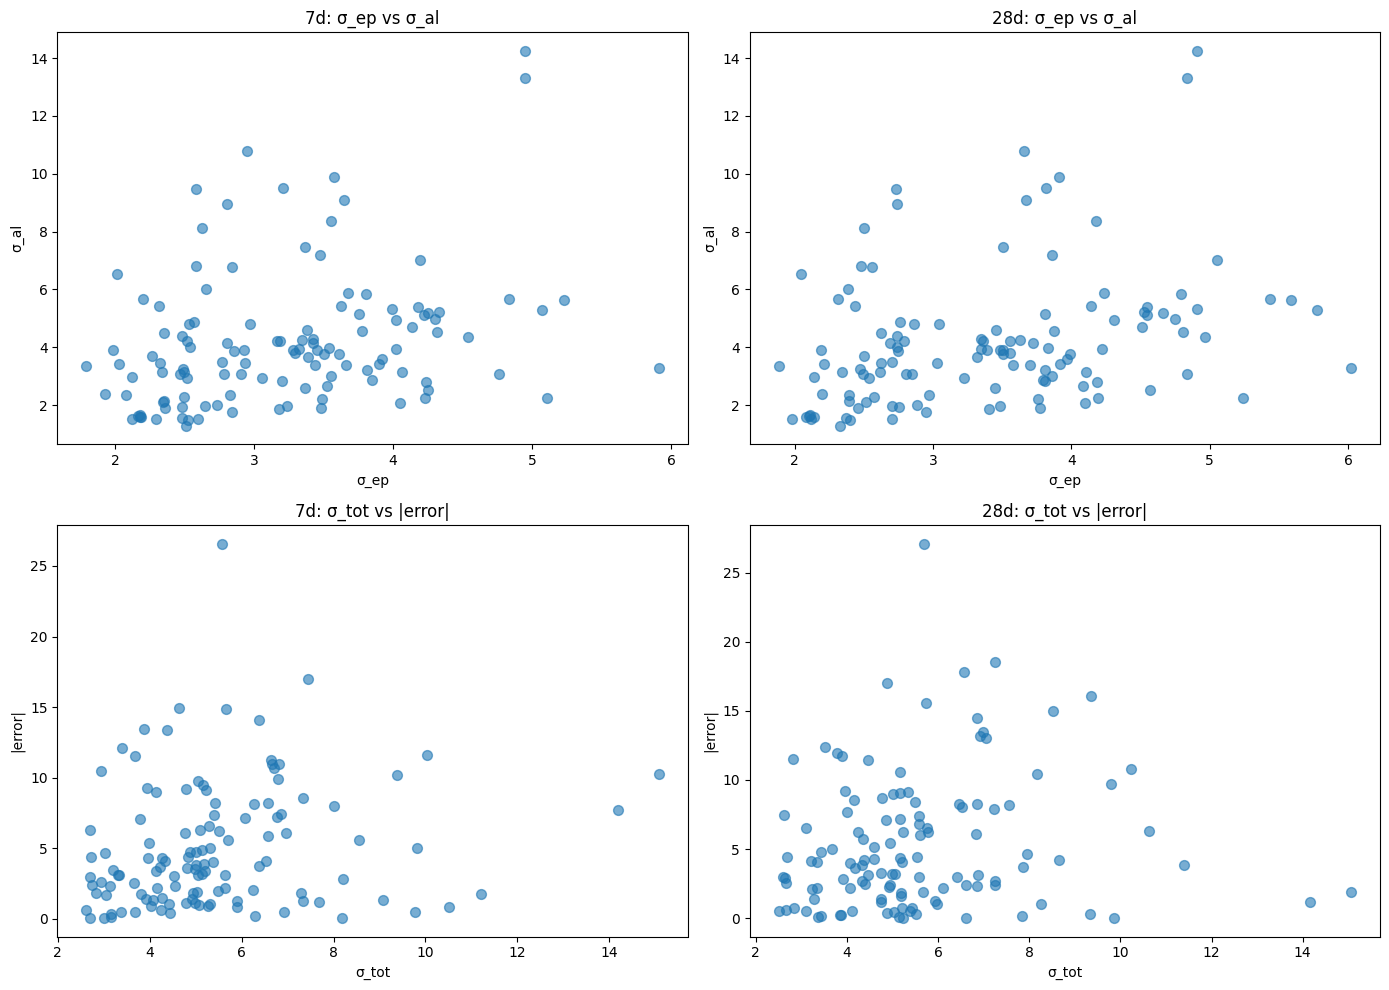


=== STEP 9: Uncertainty Components Summary ===


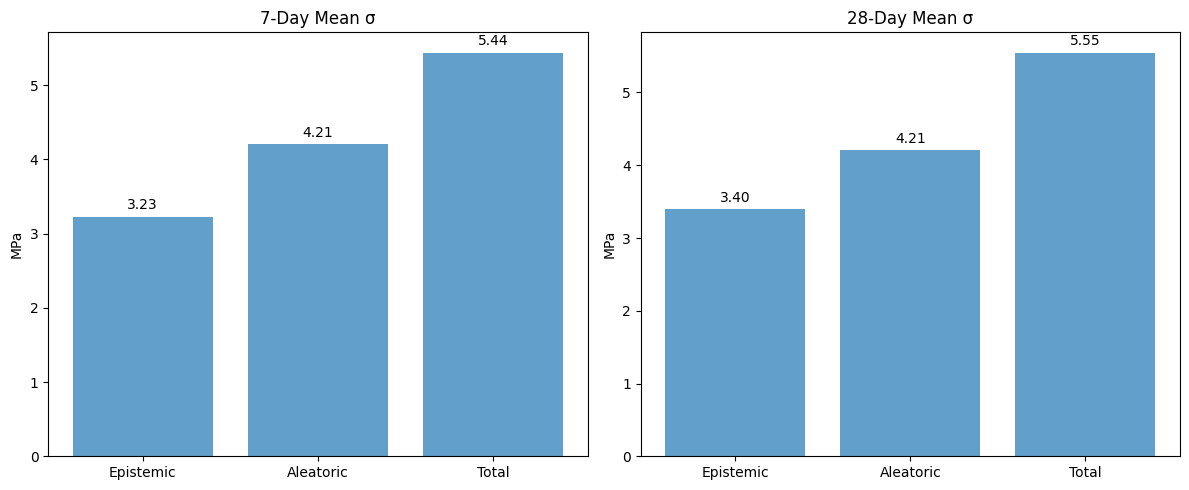

In [139]:
# =============================================================================
# ASSUMPTIONS / PREVIOUS SETUP ── 請確認下列物件已存在
# =============================================================================
# import torch, numpy as np, matplotlib.pyplot as plt
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from sklearn.isotonic import IsotonicRegression
#
# 已定義：
#   model .......................... 已訓練 PyTorch 網路
#   device ......................... "cuda" 或 "cpu"
#   mc_dropout_predict_complete .... 你的函式
#   global_target_scaler ........... 已 fit 之 StandardScaler (兩維 y)
#   X_val_scaled, X_test_scaled .... 特徵 (validation / test)
#   y7_val, y28_val ............... validation 原始 MPa
#   y7_test, y28_test ............. test 原始 MPa
# =============================================================================
from sklearn.isotonic import IsotonicRegression

# -------------------------------------------------------------------

# 時間點張量 (7 d, 28 d)
times_pred = torch.tensor([7.0, 28.0], dtype=torch.float32).to(device)

# 取出縮放因子 (StandardScaler：每維對應 1 個 scale_)
scale_factor = global_target_scaler.scale_[0]   # 兩維相同 → 取第 0 個即可

# =============================================================================
# STEP 6.5 : α-CALIBRATION ON VALIDATION SET
# =============================================================================
print("\n=== STEP 6.5: α-Calibration on Validation Set ===")

# ---------- 1) MC-Dropout 推論 ----------
z_val   = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
val_res = mc_dropout_predict_complete(model, z_val, times_pred, n_samples=500)

# ---------- 2) 還原均值 ----------
y_val_scaled = val_res['mean']               # (N_val, 2)
y7_val_mu  = global_target_scaler.inverse_transform(
                 y_val_scaled[:,0].reshape(-1,1)
             ).flatten()
y28_val_mu = global_target_scaler.inverse_transform(
                 y_val_scaled[:,1].reshape(-1,1)
             ).flatten()

# ---------- 3) 還原 total std ----------
y7_val_std  = scale_factor * val_res['total_std'][:,0]
y28_val_std = scale_factor * val_res['total_std'][:,1]

from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm

def get_z_star(y_true, mu, sigma, alpha_nom=0.1):
    """
    通过 α-校准得到新的 z*（临界值），保证两侧 nominal α = 0.05 时
    实际覆盖率 ≈ 95%。
    """
    # 1) 计算标准化残差的预测分位数 p_j = Φ(z_j)
    z       = (y_true - mu) / sigma
    p       = norm.cdf(z)               # (N,)
    
    # 2) 经验分位数 u_j = j/(N+1)
    idx     = np.argsort(z)             # 用 z 排序更合理
    u_sorted= np.arange(1, len(p)+1) / (len(p)+1)
    
    # 3) 拟合 isotonic: u → p（经验分位数到预测分位数的映射）
    iso_inv = IsotonicRegression(
        y_min=0.0, y_max=1.0, out_of_bounds="clip"
    )
    iso_inv.fit(u_sorted, p[idx])       # g_inv: u → p

    # 4) 找到 nominal α/2 在经验 CDF 上对应的预测分位数
    p_cal_half = iso_inv.predict([alpha_nom/2])[0]
    
    # 5) z* = |Φ⁻¹(p_cal_half)|，双侧对称
    z_star = abs(norm.ppf(p_cal_half))
    
    # （可选）计算校准后的 α：α_cal = 2 * p_cal_half
    alpha_cal = 2 * p_cal_half
    
    return z_star, alpha_cal



z_star_7, alpha_7 = get_z_star(y_7_val_raw,  y7_val_mu,  y7_val_std)
z_star_28, alpha_28 = get_z_star(y_28_val_raw, y28_val_mu, y28_val_std)

print(f"7-day: calibrated α = {alpha_7:.4f},  z* = {z_star_7:.3f}")
print(f"28-day: calibrated α = {alpha_28:.4f}, z* = {z_star_28:.3f}")

# =============================================================================
# STEP 7 : MODEL EVALUATION (TEST SET)  ── 使用 α-calibrated z*
# =============================================================================
print("\n=== STEP 7: Model Evaluation (Test Set) ===")

# ---------- 7.1) MC-Dropout 推論 ----------
z_test  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
test_res= mc_dropout_predict_complete(model, z_test, times_pred, n_samples=500)

# ---------- 7.2) 均值反轉 ----------
y_pred_scaled = test_res['mean']
y7_mu   = global_target_scaler.inverse_transform(
             y_pred_scaled[:,0].reshape(-1,1)
         ).flatten()
y28_mu  = global_target_scaler.inverse_transform(
             y_pred_scaled[:,1].reshape(-1,1)
         ).flatten()

# ---------- 7.3) 各種 σ ----------
epi_std_scaled = test_res['epistemic_std']
ale_std_scaled = test_res['aleatoric_std']
tot_std_scaled = test_res['total_std']

y7_epi  = scale_factor * epi_std_scaled[:,0]
y28_epi = scale_factor * epi_std_scaled[:,1]
y7_ale  = scale_factor * ale_std_scaled[:,0]
y28_ale = scale_factor * ale_std_scaled[:,1]

y7_tot  = scale_factor * tot_std_scaled[:,0]
y28_tot = scale_factor * tot_std_scaled[:,1]

# ---------- 7.4) α-calibrated CI ----------
ci7_lo  = y7_mu  - z_star_7  * y7_tot
ci7_hi  = y7_mu  + z_star_7  * y7_tot
ci28_lo = y28_mu - z_star_28 * y28_tot
ci28_hi = y28_mu + z_star_28 * y28_tot

# ---------- 7.5) 指標 ----------
def metrics(y_true, y_hat):
    return (r2_score(y_true, y_hat),
            mean_absolute_error(y_true, y_hat),
            np.sqrt(mean_squared_error(y_true, y_hat)))

r2_7,  mae_7,  rmse_7  = metrics(y_7_test_raw,  y7_mu)
r2_28, mae_28, rmse_28 = metrics(y_28_test_raw, y28_mu)
cov7  = np.mean((y_7_test_raw  >= ci7_lo)  & (y_7_test_raw  <= ci7_hi))
cov28 = np.mean((y_28_test_raw >= ci28_lo) & (y_28_test_raw <= ci28_hi))

print(f"\n7-day → R²: {r2_7:.4f}, MAE: {mae_7:.2f}, RMSE: {rmse_7:.2f}, 95% CI coverage: {cov7:.1%}")
print(f"28-day → R²: {r2_28:.4f}, MAE: {mae_28:.2f}, RMSE: {rmse_28:.2f}, 95% CI coverage: {cov28:.1%}")

# =============================================================================
# STEP 8 : UNCERTAINTY DECOMPOSITION FIGURES
# =============================================================================
print("\n=== STEP 8: Uncertainty Decomposition ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,10))

ax1.scatter(y7_epi, y7_ale, alpha=0.6, s=50)
ax1.set_title("7d: σ_ep vs σ_al"); ax1.set_xlabel("σ_ep"); ax1.set_ylabel("σ_al")

ax2.scatter(y28_epi, y28_ale, alpha=0.6, s=50)
ax2.set_title("28d: σ_ep vs σ_al"); ax2.set_xlabel("σ_ep"); ax2.set_ylabel("σ_al")

ax3.scatter(y7_tot,  np.abs(y_7_test_raw  - y7_mu),  alpha=0.6, s=50)
ax3.set_title("7d: σ_tot vs |error|"); ax3.set_xlabel("σ_tot"); ax3.set_ylabel("|error|")

ax4.scatter(y28_tot, np.abs(y_28_test_raw - y28_mu), alpha=0.6, s=50)
ax4.set_title("28d: σ_tot vs |error|"); ax4.set_xlabel("σ_tot"); ax4.set_ylabel("|error|")

plt.tight_layout(); plt.show()

# =============================================================================
# STEP 9 : MEAN UNCERTAINTY BARS
# =============================================================================
print("\n=== STEP 9: Uncertainty Components Summary ===")

fig, (bx1, bx2) = plt.subplots(1,2, figsize=(12,5))
cats = ['Epistemic','Aleatoric','Total']

vals7  = [y7_epi.mean(),  y7_ale.mean(),  y7_tot.mean()]
vals28 = [y28_epi.mean(), y28_ale.mean(), y28_tot.mean()]

bx1.bar(cats, vals7, alpha=0.7);  bx1.set_title("7-Day Mean σ");  bx1.set_ylabel("MPa")
bx2.bar(cats, vals28, alpha=0.7); bx2.set_title("28-Day Mean σ"); bx2.set_ylabel("MPa")

for i,v in enumerate(vals7):  bx1.text(i, v+0.1, f"{v:.2f}", ha="center")
for i,v in enumerate(vals28): bx2.text(i, v+0.1, f"{v:.2f}", ha="center")

plt.tight_layout(); plt.show()


In [141]:
import numpy as np

def summarize(name, arr):
    print(f"{name:20s} mean={np.mean(arr):.3f}, std={np.std(arr):.3f}, "
          f"min={np.min(arr):.3f}, max={np.max(arr):.3f}")

print("\n=== Uncertainty Summaries ===")
summarize("7d Epistemic",  y7_epi)
summarize("7d Aleatoric",  y7_ale)
summarize("7d Total",       y7_tot)
summarize("28d Epistemic", y28_epi)
summarize("28d Aleatoric", y28_ale)
summarize("28d Total",      y28_tot)



=== Uncertainty Summaries ===
7d Epistemic         mean=3.225, std=0.843, min=1.792, max=5.910
7d Aleatoric         mean=4.206, std=2.335, min=1.293, max=14.245
7d Total             mean=5.439, std=2.161, min=2.614, max=15.080
28d Epistemic        mean=3.400, std=0.949, min=1.884, max=6.023
28d Aleatoric        mean=4.206, std=2.335, min=1.293, max=14.245
28d Total            mean=5.549, std=2.192, min=2.500, max=15.067


In [142]:
# Compute calibrated total uncertainty for each sample
y7_tot_cal   = z_star_7  * y7_tot
y28_tot_cal  = z_star_28 * y28_tot

# Summarize
print("\n=== Calibrated Total Uncertainty Summaries ===")
summarize("7d Total (cal)",  y7_tot_cal)
summarize("28d Total (cal)", y28_tot_cal)



=== Calibrated Total Uncertainty Summaries ===
7d Total (cal)       mean=13.668, std=5.430, min=6.568, max=37.892
28d Total (cal)      mean=15.410, std=6.088, min=6.943, max=41.841


In [133]:
# calibrated total σ for each sample
y7_tot_cal   = z_star_7  * y7_tot   # already scaled σ_tot7
y28_tot_cal  = z_star_28 * y28_tot  # already scaled σ_tot28

print("\n=== Calibrated Total Uncertainties per Sample ===")
for i in range(len(y7_tot_cal)):
    print(f"Sample {i:3d} | "
          f"7d total(cal)  = {y7_tot_cal[i]:6.3f} MPa  | "
          f"28d total(cal) = {y28_tot_cal[i]:6.3f} MPa")



=== Calibrated Total Uncertainties per Sample ===
Sample   0 | 7d total(cal)  =  5.628 MPa  | 28d total(cal) =  5.252 MPa
Sample   1 | 7d total(cal)  = 10.374 MPa  | 28d total(cal) = 10.940 MPa
Sample   2 | 7d total(cal)  = 16.722 MPa  | 28d total(cal) = 16.576 MPa
Sample   3 | 7d total(cal)  =  5.496 MPa  | 28d total(cal) =  5.300 MPa
Sample   4 | 7d total(cal)  =  8.314 MPa  | 28d total(cal) =  8.240 MPa
Sample   5 | 7d total(cal)  =  8.389 MPa  | 28d total(cal) =  8.770 MPa
Sample   6 | 7d total(cal)  = 10.952 MPa  | 28d total(cal) = 11.669 MPa
Sample   7 | 7d total(cal)  = 21.637 MPa  | 28d total(cal) = 21.687 MPa
Sample   8 | 7d total(cal)  =  5.860 MPa  | 28d total(cal) =  5.646 MPa
Sample   9 | 7d total(cal)  = 11.352 MPa  | 28d total(cal) = 11.557 MPa
Sample  10 | 7d total(cal)  =  9.737 MPa  | 28d total(cal) =  9.715 MPa
Sample  11 | 7d total(cal)  = 25.838 MPa  | 28d total(cal) = 25.822 MPa
Sample  12 | 7d total(cal)  =  6.000 MPa  | 28d total(cal) =  5.658 MPa
Sample  13 | 

In [134]:
# =============================================================================
# Print out per-sample prediction errors
# =============================================================================
print("\n=== Test Set Prediction Errors per Sample ===")
# raw error and absolute error for 7d / 28d
errors7     = y_7_test_raw   - y7_mu
errors28    = y_28_test_raw  - y28_mu
abs_errors7 = np.abs(errors7)
abs_errors28= np.abs(errors28)

for i in range(len(errors7)):
    print(f"Sample {i:3d} | "
          f"7d error = {errors7[i]:6.3f} MPa (|{abs_errors7[i]:.3f}|) | "
          f"28d error = {errors28[i]:6.3f} MPa (|{abs_errors28[i]:.3f}|)")



=== Test Set Prediction Errors per Sample ===
Sample   0 | 7d error =  3.806 MPa (|3.806|) | 28d error =  3.064 MPa (|3.064|)
Sample   1 | 7d error = -12.560 MPa (|12.560|) | 28d error = -14.341 MPa (|14.341|)
Sample   2 | 7d error =  9.838 MPa (|9.838|) | 28d error =  4.845 MPa (|4.845|)
Sample   3 | 7d error = -0.111 MPa (|0.111|) | 28d error =  0.290 MPa (|0.290|)
Sample   4 | 7d error =  3.835 MPa (|3.835|) | 28d error =  2.812 MPa (|2.812|)
Sample   5 | 7d error = -6.451 MPa (|6.451|) | 28d error = -7.160 MPa (|7.160|)
Sample   6 | 7d error =  2.074 MPa (|2.074|) | 28d error =  1.617 MPa (|1.617|)
Sample   7 | 7d error = -9.868 MPa (|9.868|) | 28d error = -9.926 MPa (|9.926|)
Sample   8 | 7d error =  2.826 MPa (|2.826|) | 28d error =  2.532 MPa (|2.532|)
Sample   9 | 7d error = -2.460 MPa (|2.460|) | 28d error = -0.575 MPa (|0.575|)
Sample  10 | 7d error = -1.162 MPa (|1.162|) | 28d error = -1.795 MPa (|1.795|)
Sample  11 | 7d error =  4.705 MPa (|4.705|) | 28d error =  7.601 MPa

In [135]:
# 假设 ci7_lo, ci7_hi, ci28_lo, ci28_hi 已经算好
picp7  = np.mean((y_7_test_raw  >= ci7_lo)  & (y_7_test_raw  <= ci7_hi))
picp28 = np.mean((y_28_test_raw >= ci28_lo) & (y_28_test_raw <= ci28_hi))

print(f"PICP (7-day)  = {picp7: .1%}")
print(f"PICP (28-day) = {picp28: .1%}")


PICP (7-day)  =  92.6%
PICP (28-day) =  93.4%


In [136]:
# =============================================================================
# Compute Mean Interval Coverage Width (MICW)
# =============================================================================
# ci7_lo, ci7_hi, ci28_lo, ci28_hi 已在前面算好

micw7  = np.mean(ci7_hi  - ci7_lo)
micw28 = np.mean(ci28_hi - ci28_lo)

print(f"\nMICW (7-day)  = {micw7:.3f} MPa")
print(f"MICW (28-day) = {micw28:.3f} MPa")



MICW (7-day)  = 23.778 MPa
MICW (28-day) = 23.941 MPa
